# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = 50
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import numpy as np
import math
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})


color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color

### <span style="color:Khaki;">Reading cleaned Dataset:

In [2]:
df=pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
761                 440       2007-03-15           IL               1000   
727                  39       1993-01-28           IN                500   
988                 295       1999-01-09           IN                500   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
761        MALE                 College    protective-serv       paintball   
727        MALE                      JD    farming-fishing            polo   
988      FEMALE             High School       armed-forces         dancing   

    insured_relationship incident_date             incident_type  \
761                 wife    2015-02-02   Multi-vehicle Collision   
727        not-in-family    2015-02-14  Single Vehicle Collision   
988                 wife    2015-02-17  Single Vehicle Collision   

     collision_type incident_severity authorities_contacted incident_state  \
761  Rear Collision      Major Damage                Police             SC   
727  Rear Collision      Major Damage                Police             SC   
988  Rear Collision      Minor Damage                  Fire             NY   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
761     Arlington                       19                           3   
727     Northbend                       14                           1   
988      Columbus                        5                           1   

    property_damage bodily_injuries witnesses police_report_available  \
761             YES               0         3                      NO   
727             YES               0         1                      NO   
988             YES               1         1                      NO   

    auto_make auto_year fraud_reported  age_boxcox  \
761      Jeep      2007              Y      4.7266   
727    Suburu      2009              Y      3.4807   
988     Honda      1997              N      4.4382   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
761                      997.9114                143490.2337   
727                     1176.2815                184336.2619   
988                     1678.0253                126626.3108   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
761              28672                28672           101252.1048  
727              15552               -22632           150889.0336  
988             -30528                -3816            98946.1314

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   months_as_customer            1000 non-null   int16         
 1   policy_bind_date              1000 non-null   datetime64[ns]
 2   policy_state                  1000 non-null   category      
 3   policy_deductable             1000 non-null   int16         
 4   insured_sex                   1000 non-null   category      
 5   insured_education_level       1000 non-null   category      
 6   insured_occupation            1000 non-null   category      
 7   insured_hobbies               1000 non-null   category      
 8   insured_relationship          1000 non-null   category      
 9   incident_date                 1000 non-null   datetime64[ns]
 10  incident_type                 1000 non-null   category      
 11  collision_type                1

## <span style="color:Aqua;">Defining variable type:

<span style="color: Chartreuse;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &#9784; </span> On a high level we can categorize data into two types <span style="color: Chartreuse;"> Continuous and Categorial </span> In this section we are gonna split features based on the nature of it's type.<br>



   <span style="color: Chartreuse;font-size:130%;"> &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&#9830; </span> Continuous variables can take any value within a range and can habe infinite possible values. 
      <p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;Example - `annual_income`, `age`, `Num of bank accounts`, etc. </p>

   <span style="color: Chartreuse;font-size:130%;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> Continuous Categorial variables have categories with specific order or ranking or represent categories without any inherent or order or ranking. 
      <p> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;- Example - `credit_mix`,`name`, etc.</p>

In [9]:
continuous = ['age_boxcox', 'policy_deductable',
       'policy_annual_premium_boxcox', 'total_claim_amount_boxcox', 'injury_claim_cube',
       'property_claim_cube', 'vehicle_claim_boxcox']

categorical = ['policy_state', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'auto_make', 'auto_year', 'fraud_reported']
date = ['policy_bind_date','incident_date'] 


In [10]:
print(len(continuous + categorical + date))
print(df.shape[1] -1) # Remonving month since customer

30
30


## <p style="color:Aqua;"> Exploratory Data Analysis. Before Handling Skewness, Kurtosis and Outliers</p>

### <p style="color:Khaki;">Before we move further it's crucial to understand the importance of handling <span style="color: Chartreuse;"> Outliers, Normality, Skewness, and Kurtosis </span> and their impact on the ML model performance.

#### <span style="color: Tomato;font-size:130%;"><u> Outliers</u>:- </span> 
Outliers are data points that are significantly different from most other data points in a variable (column). Example, most people in a dataset have an annual income between $20,000 and $100,000, but one person has an income of $1,000,000, that person is an outlier.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Example:- </span> Most people in a dataset have an annual income between $20,000 and $100,000, but one person has an income of $1,000,000, that person is an outlier.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Outliers can skew the results of our analysis and make our model less accurate. For example, if we're predicting loan approval, an outlier income might distort the overall understanding of what typical incomes look like, leading to poor predictions.

#### <span style="color: Tomato;font-size:130%;"> <u>Normality</u>:- 
</span>Normality refers to how data is distributed. In a "normal" distribution, data is symmetrically distributed around the mean (average), forming a bell-shaped curve when we plot a line chart.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Example:- </span> Imagine measuring the height of adults in a city. Most people would fall around the average height, with fewer people being extremely short or extremely tall, forming a bell curve.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Many statistical models assume that the data follows a normal distribution. If our data is not normally distributed, the model might not perform as well, leading to inaccurate predictions.

#### <span style="color: Tomato;font-size:130%;"> <u>Skewness</u>:- 
</span>Skewness measures the asymmetry of the data distribution. If data is skewed, it means that it is not evenly distributed around the mean.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> <u>Types of Skewness</u>:- </span><br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Positive Skew (Right Skew):- </span> Most data points are clustered on the left with a few high values stretching out to the right.<br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Negative Skew (Left Skew):- </span> Most data points are clustered on the right with a few low values stretching out to the left.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> Skewed data can affect the performance of our model by giving more weight to the tail-end values, which might not be representative of the majority of our data.

#### <span style="color: Tomato;font-size:130%;"> <u>Kurtosis</u>:- 
</span>Kurtosis measures the "tailedness" of the data distribution. It tells us how much data is in the tails and the peak compared to a normal distribution.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> <u>Types of Kurtosis</u>:- </span><br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> High Kurtosis:- </span> Data has heavy tails and a sharp peak, indicating more extreme values.<br>

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9824; </span><span style="color: Tomato;font-size:100%;"> Low Kurtosis:- </span> Data has light tails and a flatter peak, indicating fewer extreme values.

<span style="color: Chartreuse;font-size:120%;"> &nbsp; &nbsp;&nbsp;&nbsp;&#9830; </span> <span style="color: Tomato;font-size:110%;"> Impact on Model:- </span> High kurtosis can indicate the presence of outliers, which can affect the accuracy of our model. If the data has more extreme values than expected, our model might overestimate the variability and lead to poor predictions.

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to create plots.</span></span><br>

In [12]:
def univar_num(df, col):
    plt.figure(figsize=(16, 8))
    df = df.dropna(subset=[col])


    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode()[0]
    sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})
    plt.subplot(2, 3, 1)
    sns.histplot(data=df, x=col, kde=True, bins=50,color='maroon',fill=True)
    plt.title(f'Histogram for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

    
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, x=col, color='lightgrey',legend=True)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
    plt.axvline(mean, color='maroon', label='Mean')
    plt.axvline(median, color='black', label='Median')
    plt.axvline(mode, color='darkgreen', label='Mode')
    plt.legend()
    plt.tight_layout()

    
    plt.subplot(2, 3, 3)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.gca().get_lines()[1].set_color('maroon')
    plt.gca().get_lines()[0].set_color('darkgreen')
    plt.title(f'QQ Plot for {col}',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to show Kurtosis and Skewness value.</span></span><br>

In [13]:
def kurtosis_color(kurt_val):
    if -1 <= kurt_val <= 1:
        kurt_color = color_good  # Dark Green for near-zero kurtosis (good)
    elif 1 < kurt_val <= 3 or -3 <= kurt_val < -1:
        kurt_color = color_okay  # Yellow for moderate kurtosis
    else:  # kurt_val > 3 or kurt_val < -3
        kurt_color = color_bad  # Maroon for extreme kurtosis
    return kurt_color

def skewness_color(skew_val):
    if -0.5 <= skew_val <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skew_val <= 0.5 or -0.5 < skew_val < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
    return color

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> Defining a function to to plot</span></span><br>

In [14]:
def process_column(col):
    univar_num(df, col) 
    skew_val = df[col].skew()
    kurt = df[col].kurtosis()
    
    kurt_color = kurtosis_color(kurt)
    color = skewness_color(skew_val)
    
    skewed_col.append(col)
    
    print(f"\n\n{color}Skew for {col} is {skew_val:.4f}{color_neutral}")
    print(f"{color}Kurtosis for {col} is {kurt:.4f}{color_neutral}\n\n")


### <span style="color:Khaki;"> Descrptive Statistics:

In [15]:
df.describe().T

count                           mean  \
months_as_customer           1000.0000                       203.9540   
policy_bind_date                  1000  2002-02-08 04:40:47.999999872   
policy_deductable            1000.0000                      1136.0000   
incident_date                     1000            2015-01-30 08:02:24   
age_boxcox                   1000.0000                         4.1843   
policy_annual_premium_boxcox 1000.0000                      1259.8295   
total_claim_amount_boxcox    1000.0000                    110321.7677   
injury_claim_cube            1000.0000                     -1242.4640   
property_claim_cube          1000.0000                      -542.7760   
vehicle_claim_boxcox         1000.0000                     88774.1389   

                                              min                  25%  \
months_as_customer                         0.0000             115.7500   
policy_bind_date              1990-01-08 00:00:00  1995-09-19 00:00:00   
policy_deductable                        500.0000             500.0000   
incident_date                 2015-01-01 00:00:00  2015-01-15 00:00:00   
age_boxcox                                 3.2967               3.9605   
policy_annual_premium_boxcox             433.5870            1092.3427   
total_claim_amount_boxcox                129.5888           84877.8054   
injury_claim_cube                     -32768.0000          -17536.0000   
property_claim_cube                   -32768.0000          -15930.0000   
vehicle_claim_boxcox                      92.3253           68491.5264   

                                              50%                  75%  \
months_as_customer                       199.5000             276.2500   
policy_bind_date              2002-04-01 12:00:00  2008-04-21 12:00:00   
policy_deductable                       1000.0000            2000.0000   
incident_date                 2015-01-31 00:00:00  2015-02-15 00:00:00   
age_boxcox                                 4.1851               4.3790   
policy_annual_premium_boxcox            1260.6127            1419.7602   
total_claim_amount_boxcox             120714.3523          148899.2008   
injury_claim_cube                          0.0000           14200.0000   
property_claim_cube                        0.0000           14848.0000   
vehicle_claim_boxcox                   97959.1698          120211.8718   

                                              max        std  
months_as_customer                       479.0000   115.1132  
policy_bind_date              2015-02-22 00:00:00        NaN  
policy_deductable                       2000.0000   611.8647  
incident_date                 2015-03-01 00:00:00        NaN  
age_boxcox                                 4.8844     0.3084  
policy_annual_premium_boxcox            2054.3488   245.1613  
total_claim_amount_boxcox             251198.4930 57149.0380  
injury_claim_cube                      32704.0000 18783.2391  
property_claim_cube                    32704.0000 18805.8999  
vehicle_claim_boxcox                  195682.7153 46029.5714

#### <span style="color:Khaki;"> Observations and insights from above statistical information:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Income and Debt -**</span>   There is significant income disparity, with a high standard deviation in annual income. The debt-to-income ratios and total liabilities indicate varying levels of financial burden. Monthly inhand salary follows a similar pattern.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit and Loans: -**</span> The number of credit cards and loans, along with credit utilization ratios, suggest diverse credit usage patterns among individuals. The max is 50%, suggesting no one in the dataset is severely overutilizing their credit. The debt-to-income ratio has a very high max value (101,912), indicating some individuals with extreme debt compared to income.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payments -**</span> The number of delayed payments and days delayed from the due date highlight potential issues in financial management for some individuals.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Savings and Investments -**</span> The savings rate and amount invested monthly indicate varying levels of financial planning and investment behavior.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Reliability and Stability -**</span> The reliable_payment and income_stability metrics provide insights into the financial reliability and stability of individuals. The 'reliable_payment' feature has a very high max value (2500), which might be an outlier or error.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Banking and Credit Cards: -**</span> The average number of loans is 3.53, with a range from 0 to 9. The minimum value in the interest rate suggest that all of these should have atleast 1 loan or credit card but we see datapoints that do not have either loan or credit card.

### <span style="color:Khaki;">Ploting Continuous features Distribution:

<span style="color: Chartreuse;">   &#9784; &nbsp; <span style="color: white;font-size: 120%"> The below code plots Histogram, Box plot, and Q-Q plots for all Conntimuos Features:</span></span><br>

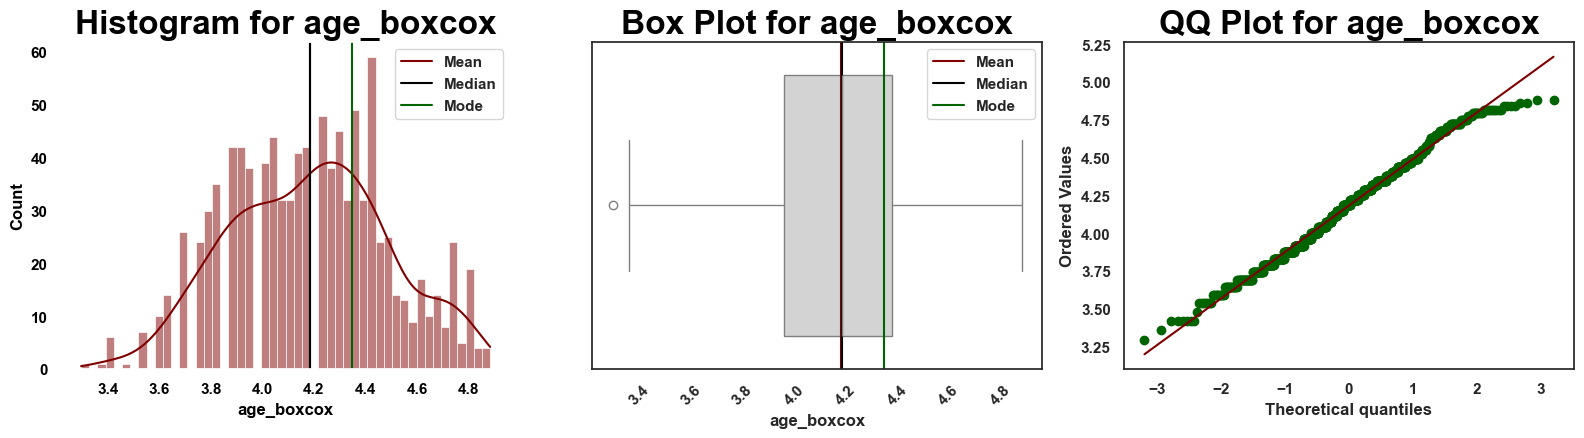



Skew for age_boxcox is -0.0029
Kurtosis for age_boxcox is -0.4858




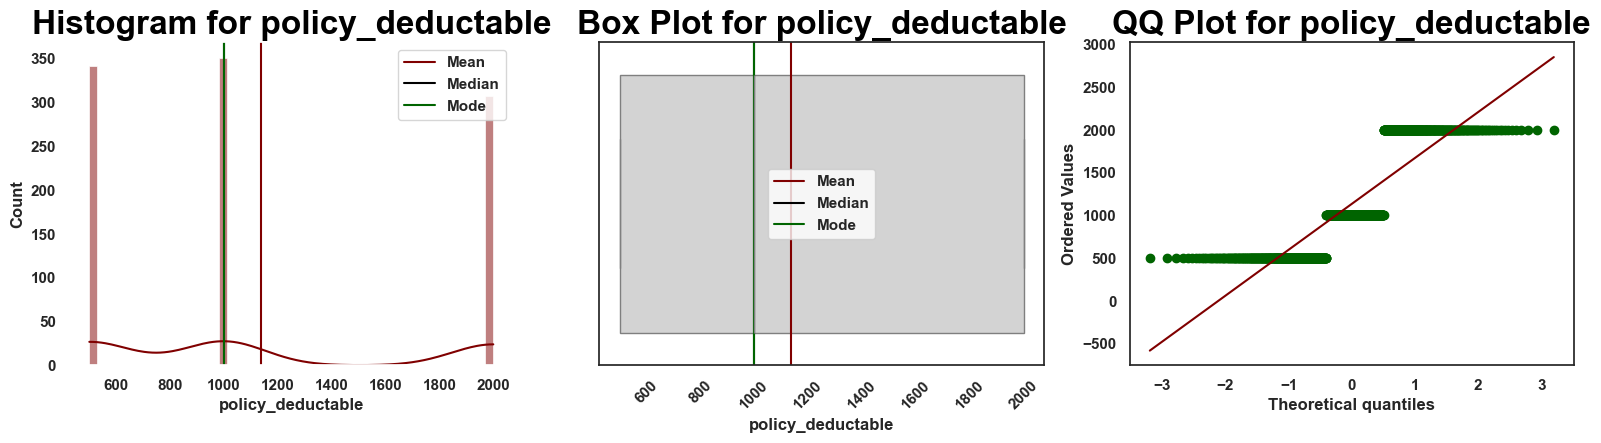



Skew for policy_deductable is 0.4779
Kurtosis for policy_deductable is -1.3769




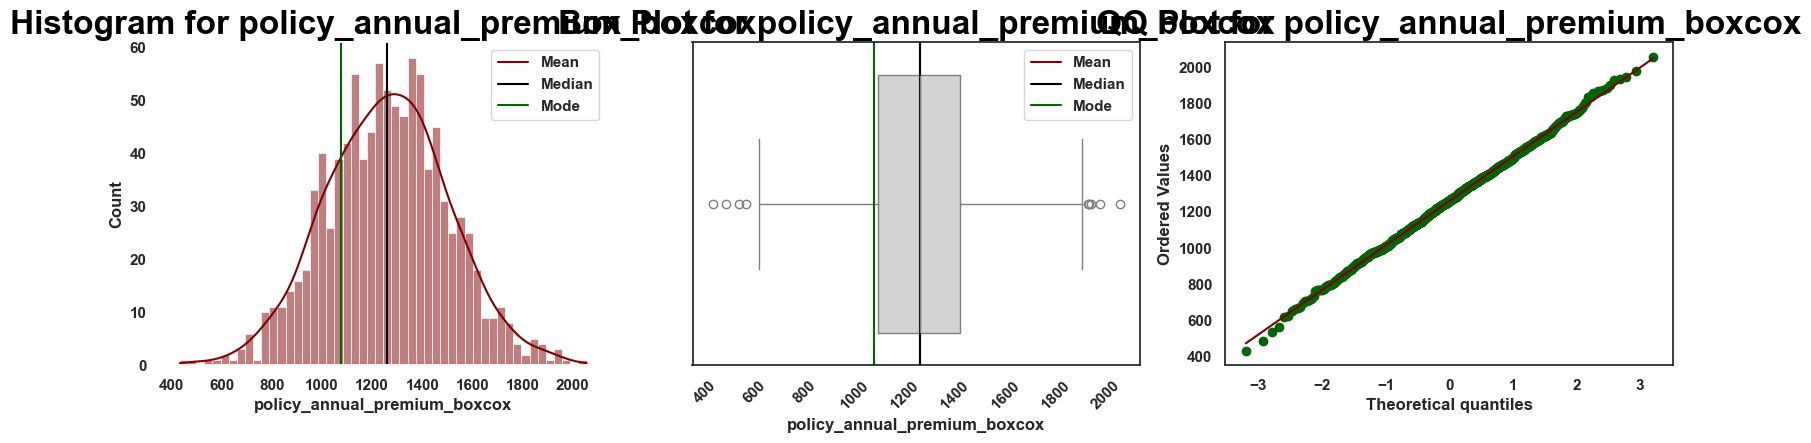



Skew for policy_annual_premium_boxcox is 0.0048
Kurtosis for policy_annual_premium_boxcox is 0.0738




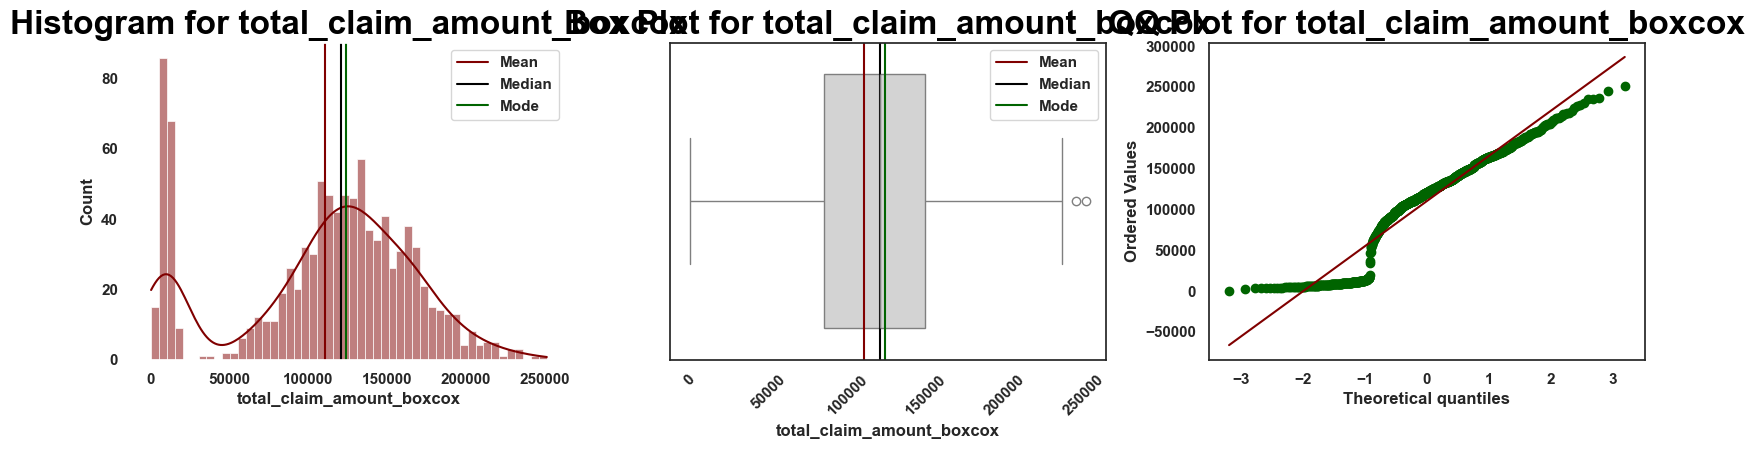



Skew for total_claim_amount_boxcox is -0.5104
Kurtosis for total_claim_amount_boxcox is -0.4878




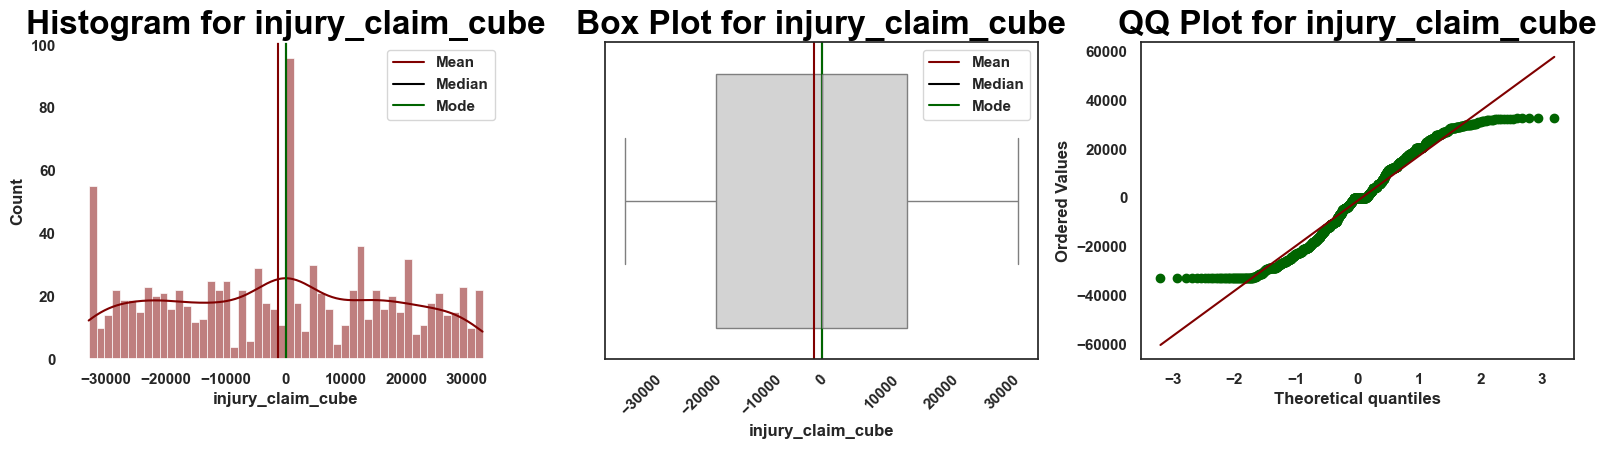



Skew for injury_claim_cube is 0.0054
Kurtosis for injury_claim_cube is -1.0722




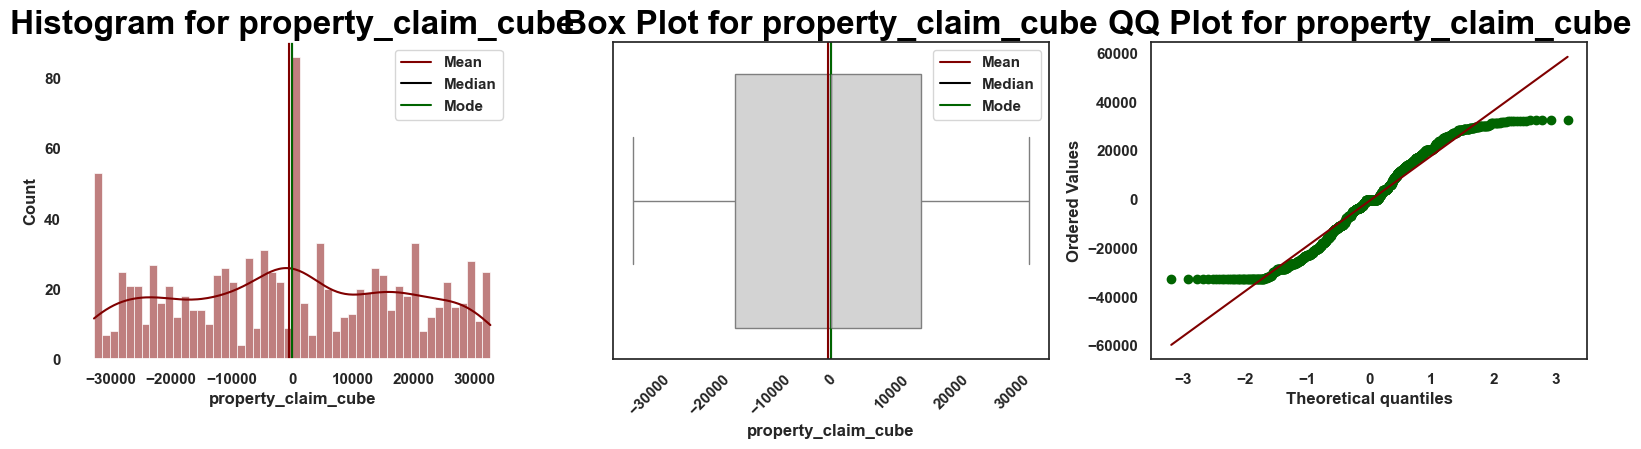



Skew for property_claim_cube is -0.0187
Kurtosis for property_claim_cube is -1.0615




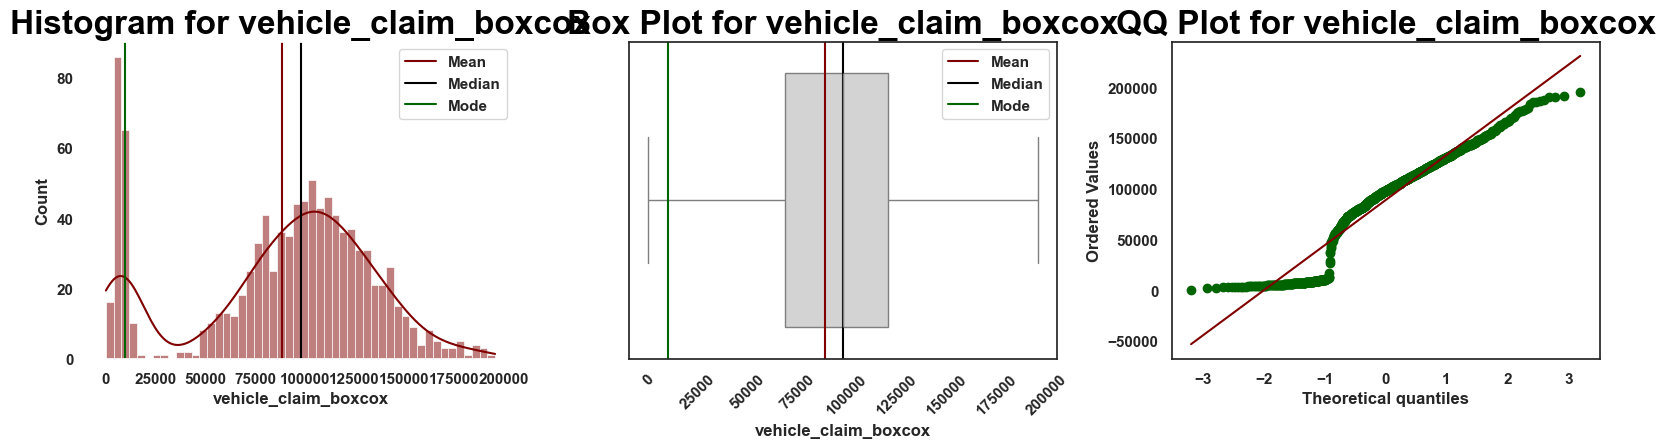



Skew for vehicle_claim_boxcox is -0.5228
Kurtosis for vehicle_claim_boxcox is -0.4890




In [16]:
skewed_col = []

_ = list(map(process_column, continuous)) # Apply the function to each column in the continuous list


#### <span style="color:Khaki;"> Observations and insights from plots above:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Histogram (First Plot) -**</span> A histogram is like a bar chart showing how often different values occur in your data. A smooth line (KDE) estimating the shape of data distribution.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Box-and-Whisker plot, (Second Plot) -**</span> The "box" represents the middle 50% of your data. The line in the middle of the box is the median. The "whiskers" extend to show the rest of the distribution.Points beyond the whiskers are potential outliers.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Q-Q Plot (Quantile-Quantile (Third plot)): -**</span> This plot compares your data's distribution to a theoretical normal distribution. It show how closely your data follows a normal distribution and Where and how your data deviates from normality.
   



   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Observations: -**</span> 
      - All features are right skewed (right tail) except `credit_utilization_ratio`, `credit_history_age`, `interest_rate`,`income_stability`. 
      - Effect of Skewness, we have outliers after the upper whisker (right side of the box plot).
      - Q-Q plot also confirms the same from the data deviation. The red line on the Q-Q plot is therotical line of Normal distribution and the green line is our data distrinbution.
      - All of these explains the presence of larger values but in smaller quantities.

<span style="color: Chartreuse;font-size: 130%">&#9784; &nbsp;</span> <span style="color: Tomato;font-size: 130%"> <b>We will need to use appropriate techniques like normalizing, capping outliers to certain percentile, etc, to address these issues</b></span>

### <span style="color:Khaki;">Statistival Test for Normality, Skew, Kurtosis:

Performing statustival test to confirm

In [17]:
for var in continuous:
    stat, p = kstest(df[var], 'norm', args=(df[var].mean(), df[var].std()))
    print(f'K-S Test for {var}: Statistics={stat}, p={p}')
    if p > 0.05:
        print(f'{var} looks normally distributed.\n')
    else:
        print(f'{var} does not look normally distributed.\n')


K-S Test for age_boxcox: Statistics=0.04388925702741664, p=0.04119400389580685
age_boxcox does not look normally distributed.

K-S Test for policy_deductable: Statistics=0.2809486814746704, p=2.61725029571265e-70
policy_deductable does not look normally distributed.

K-S Test for policy_annual_premium_boxcox: Statistics=0.011776280886439672, p=0.9988458571383247
policy_annual_premium_boxcox looks normally distributed.

K-S Test for total_claim_amount_boxcox: Statistics=0.12663530329651584, p=1.941386333880599e-14
total_claim_amount_boxcox does not look normally distributed.

K-S Test for injury_claim_cube: Statistics=0.06012635437542327, p=0.001385706234150685
injury_claim_cube does not look normally distributed.

K-S Test for property_claim_cube: Statistics=0.05746362232402735, p=0.0025987681019050773
property_claim_cube does not look normally distributed.

K-S Test for vehicle_claim_boxcox: Statistics=0.1271844608452063, p=1.4656488524295135e-14
vehicle_claim_boxcox does not look nor

In [18]:
for var in continuous:
    skewness = skew(df[var])
    kurt = kurtosis(df[var])
    print(f'{var} - Skewness: {skewness}, Kurtosis: {kurt}')
    if abs(skewness) < 0.5 and abs(kurt) < 3:
        print(f'{var} looks normally distributed.\n')
    else:
        print(f'{var} does not look normally distributed.\n')

age_boxcox - Skewness: -0.002873381384823303, Kurtosis: -0.4894168319291712
age_boxcox looks normally distributed.

policy_deductable - Skewness: 0.47717008402692257, Kurtosis: -1.3760622615437708
policy_deductable looks normally distributed.

policy_annual_premium_boxcox - Skewness: 0.0047546052331655046, Kurtosis: 0.0674182947941655
policy_annual_premium_boxcox looks normally distributed.

total_claim_amount_boxcox - Skewness: -0.5096455091351189, Kurtosis: -0.4913269384792911
total_claim_amount_boxcox does not look normally distributed.

injury_claim_cube - Skewness: 0.005439171294677157, Kurtosis: -1.0728714594053235
injury_claim_cube looks normally distributed.

property_claim_cube - Skewness: -0.018671961665450498, Kurtosis: -1.0621499569739605
property_claim_cube looks normally distributed.

vehicle_claim_boxcox - Skewness: -0.5220140975899364, Kurtosis: -0.4925960376836662
vehicle_claim_boxcox does not look normally distributed.



<span style="color: Chartreuse;font-size: 130%">&#9784; &nbsp;</span> <span style="color: Tomato;font-size: 130%"> <b>Above are the another way of checking distribution and Skewness, it representing the same results as plots.</b></span>

### <span style="color:Khaki;">Categorical features Distribution

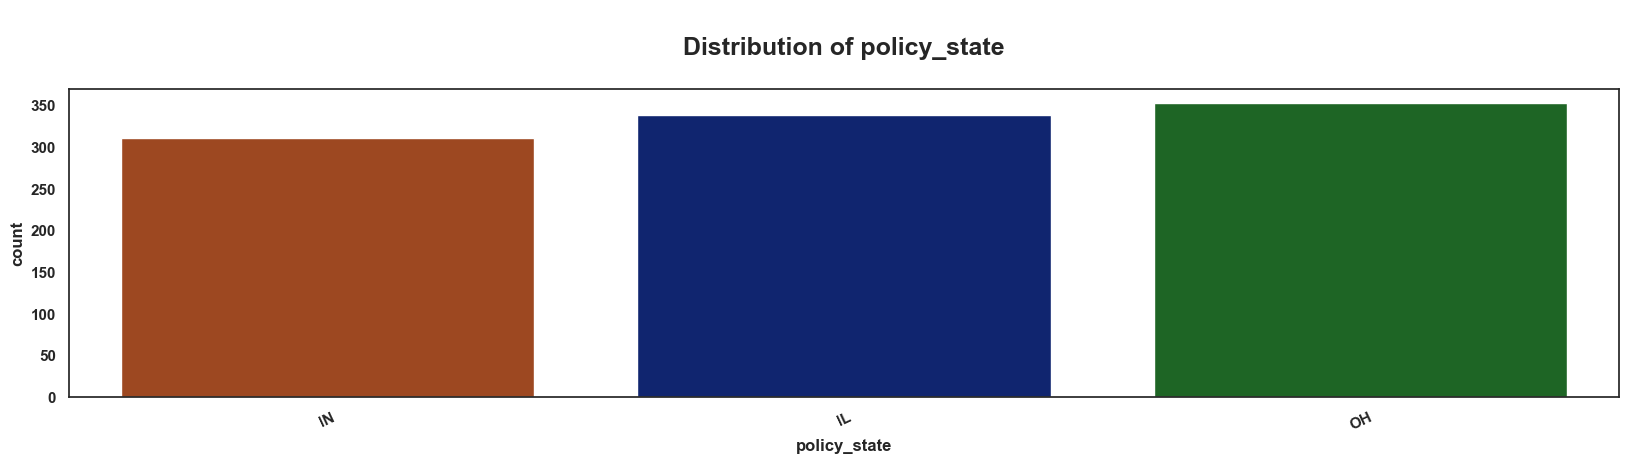

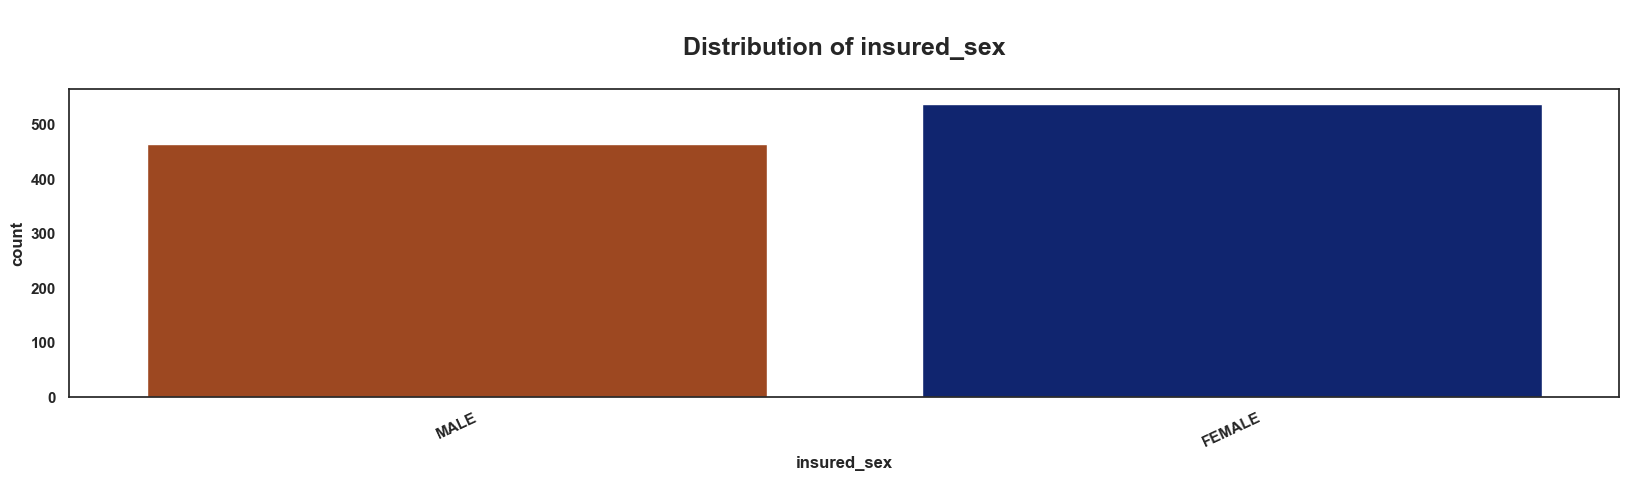

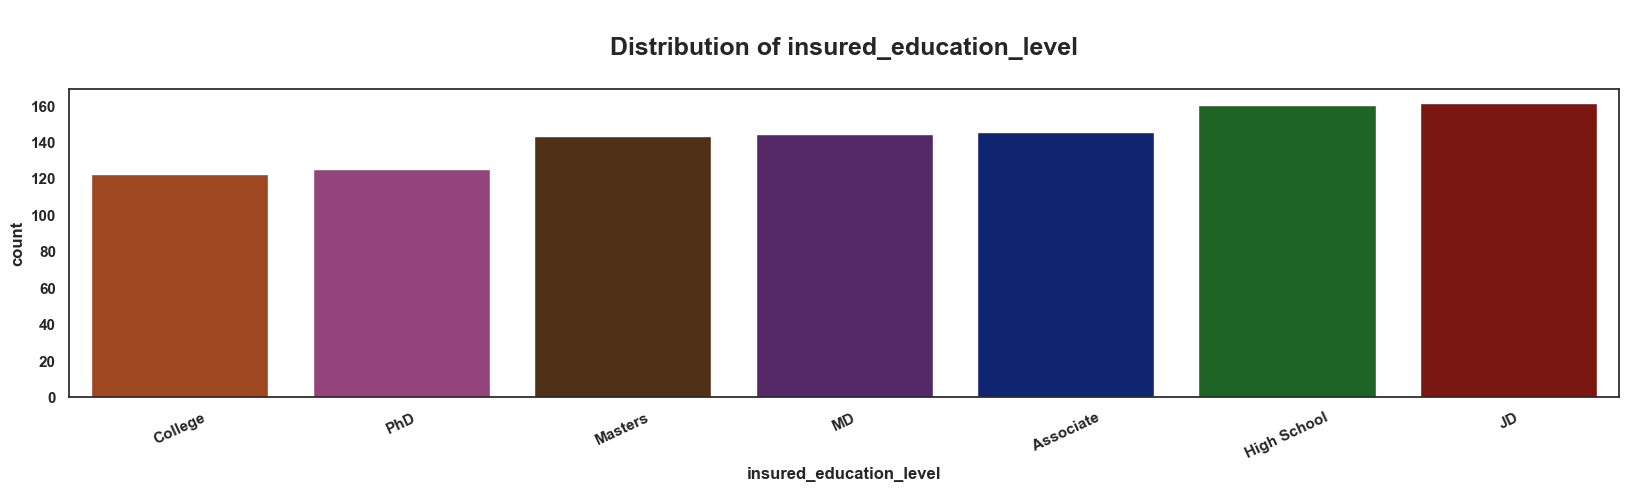

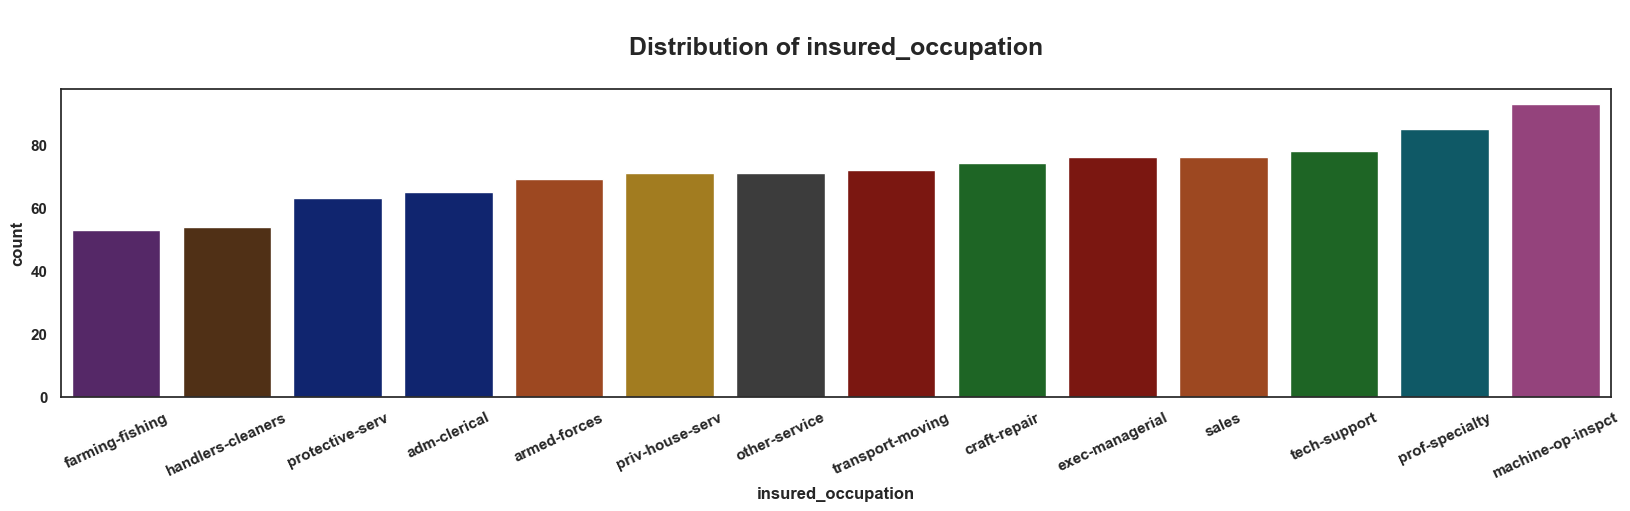

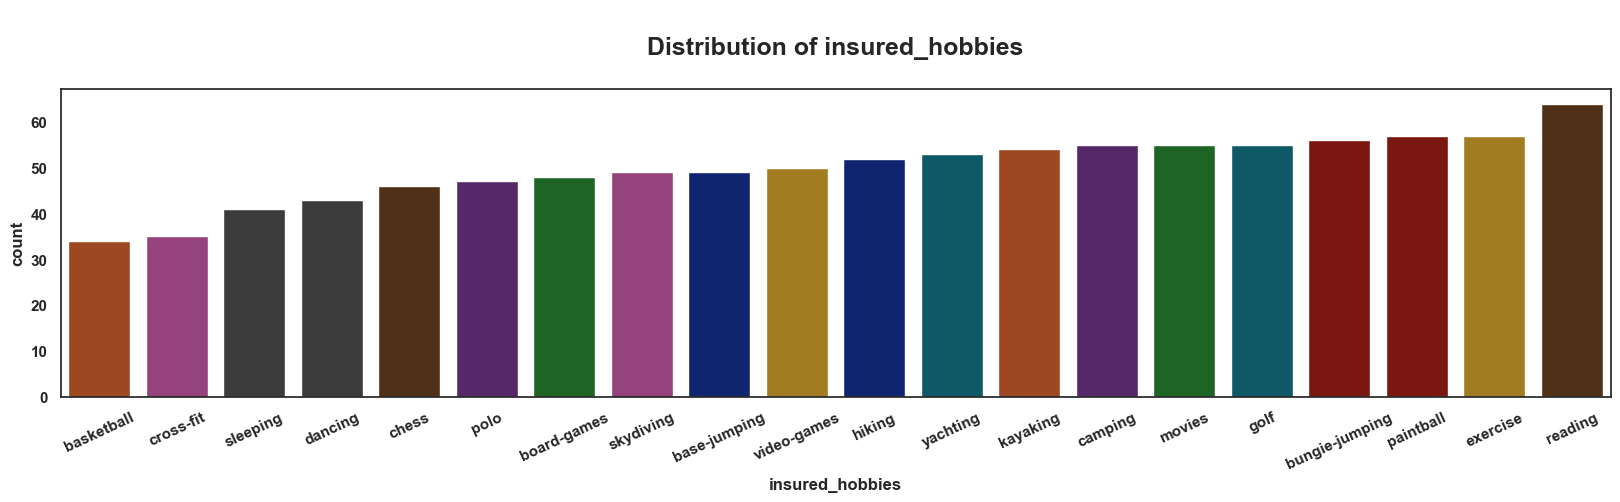

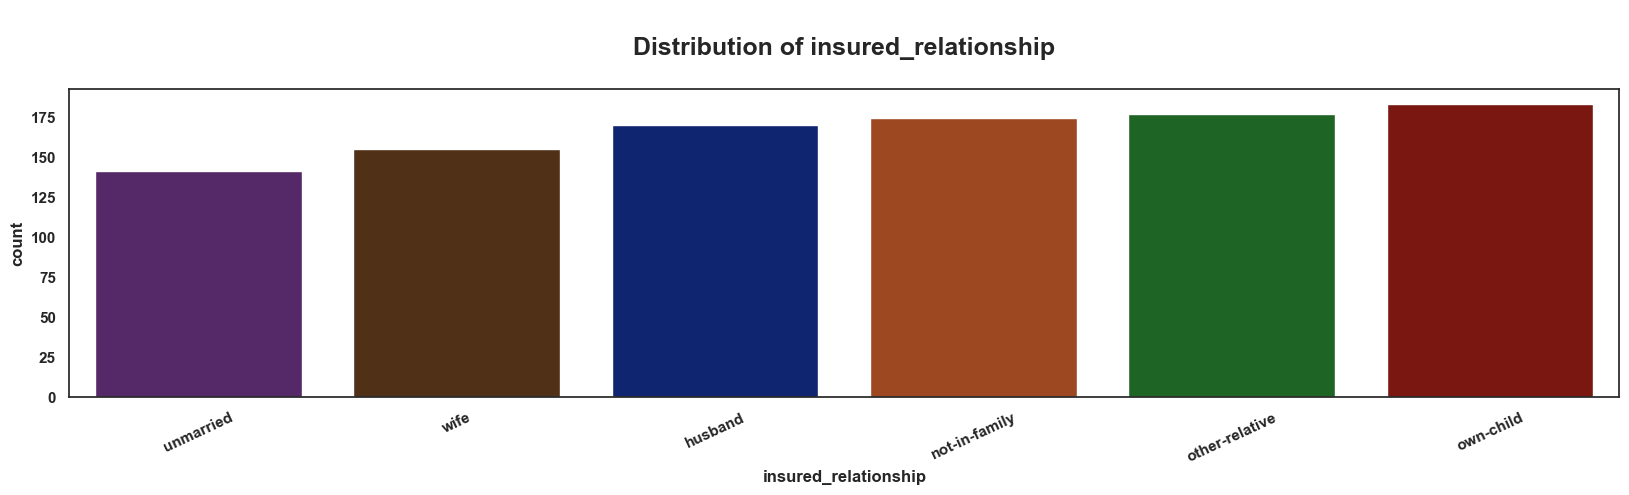

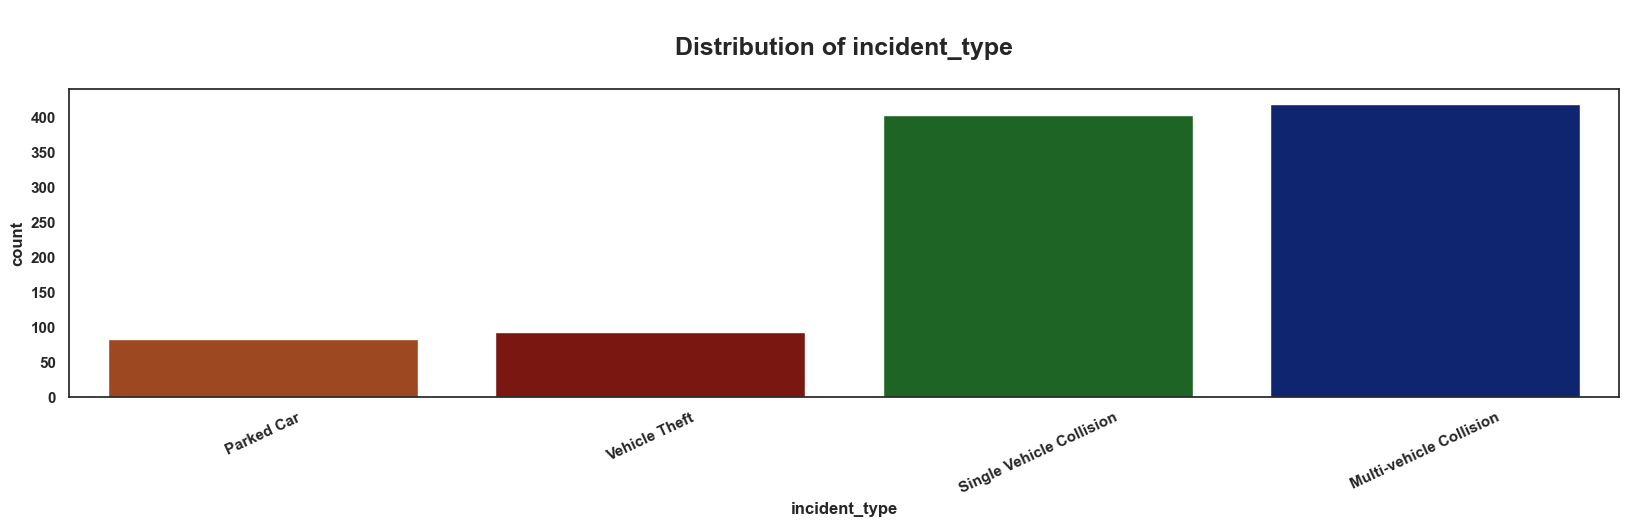

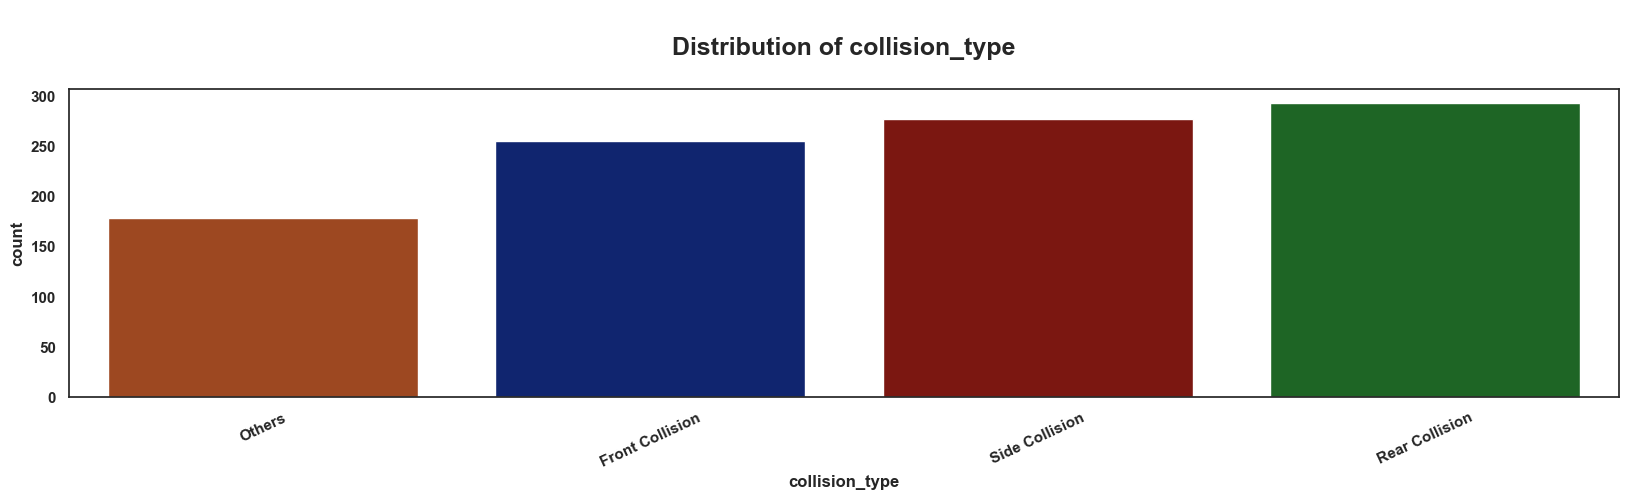

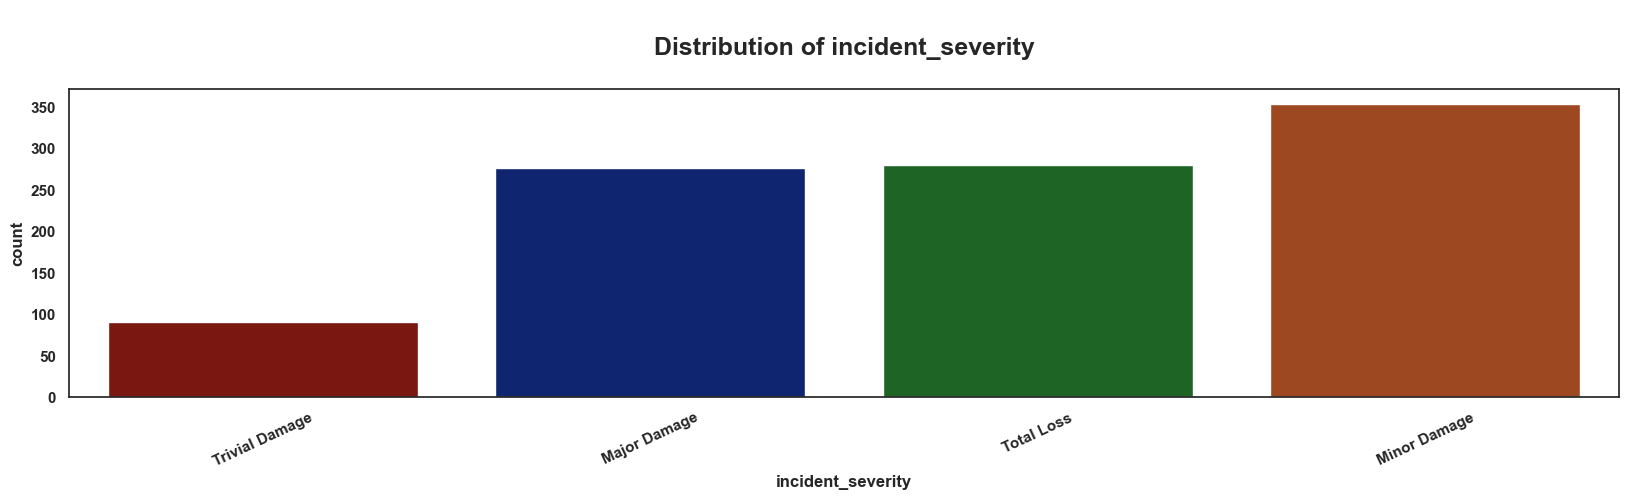

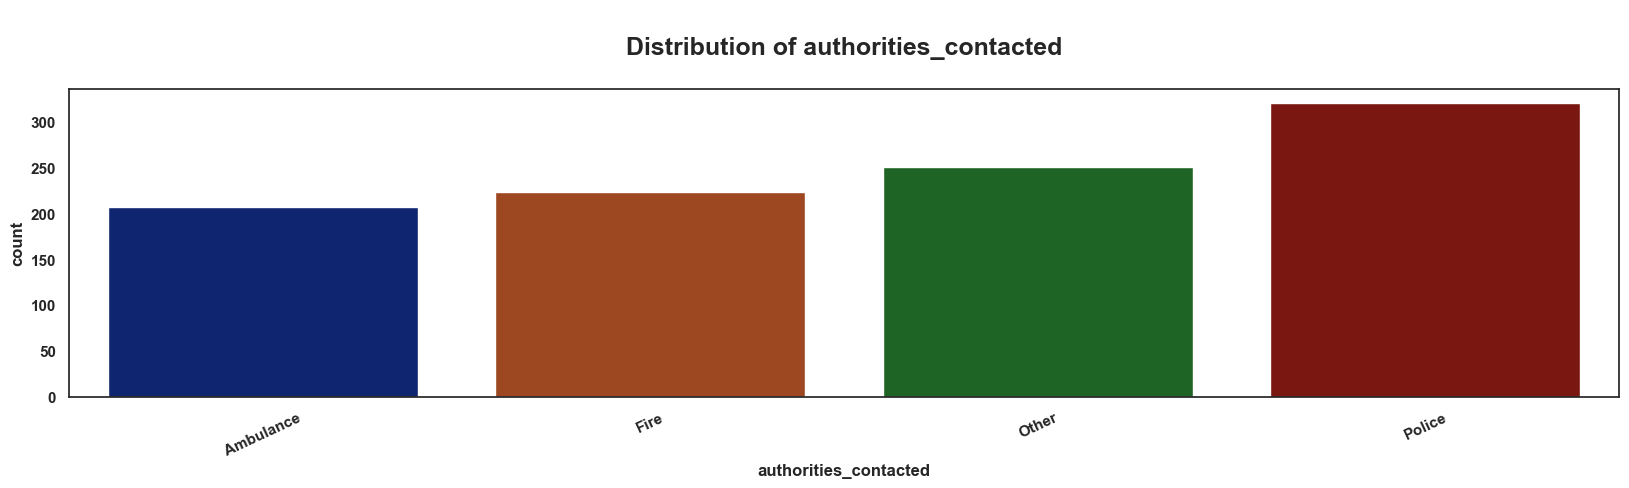

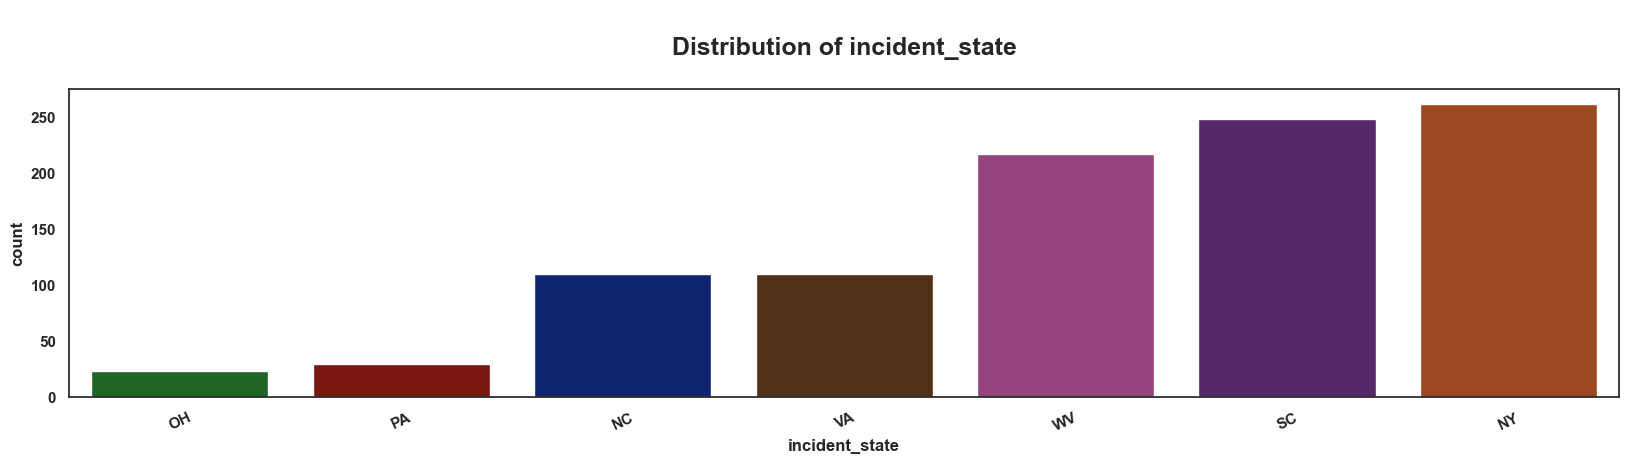

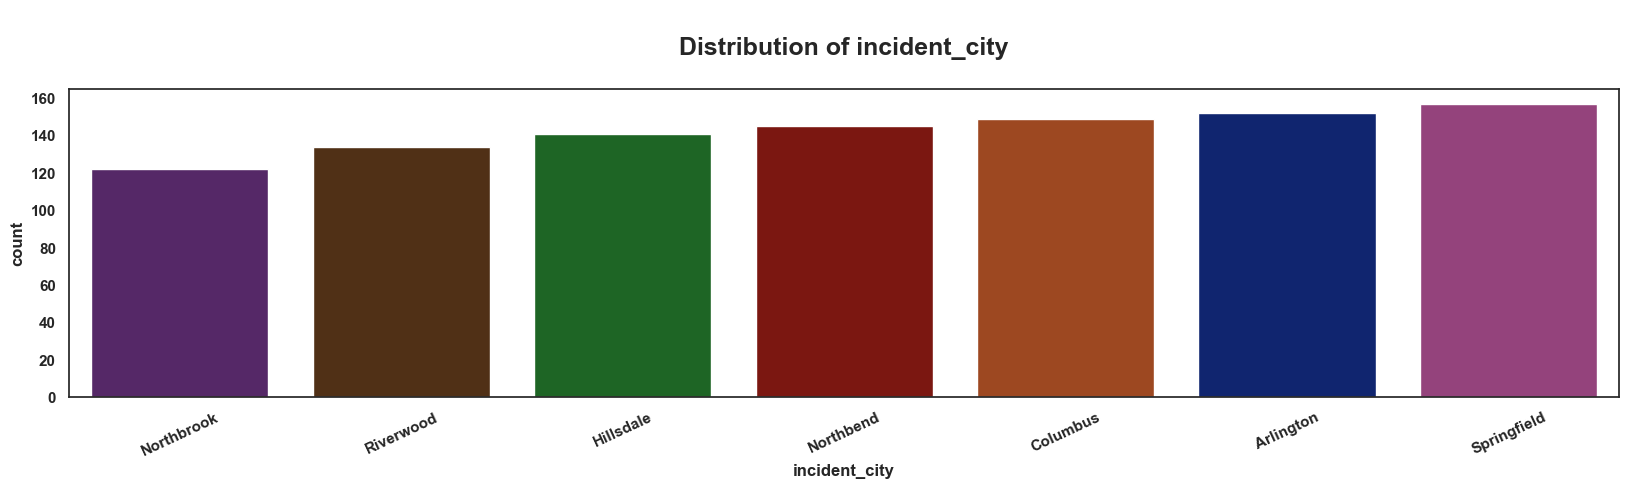

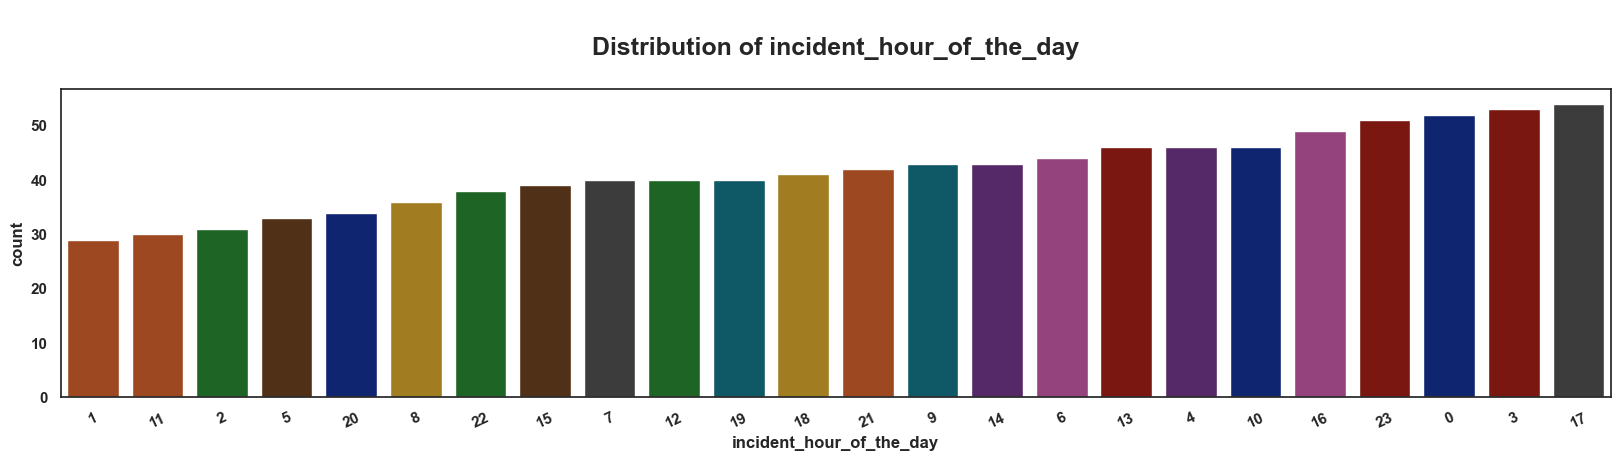

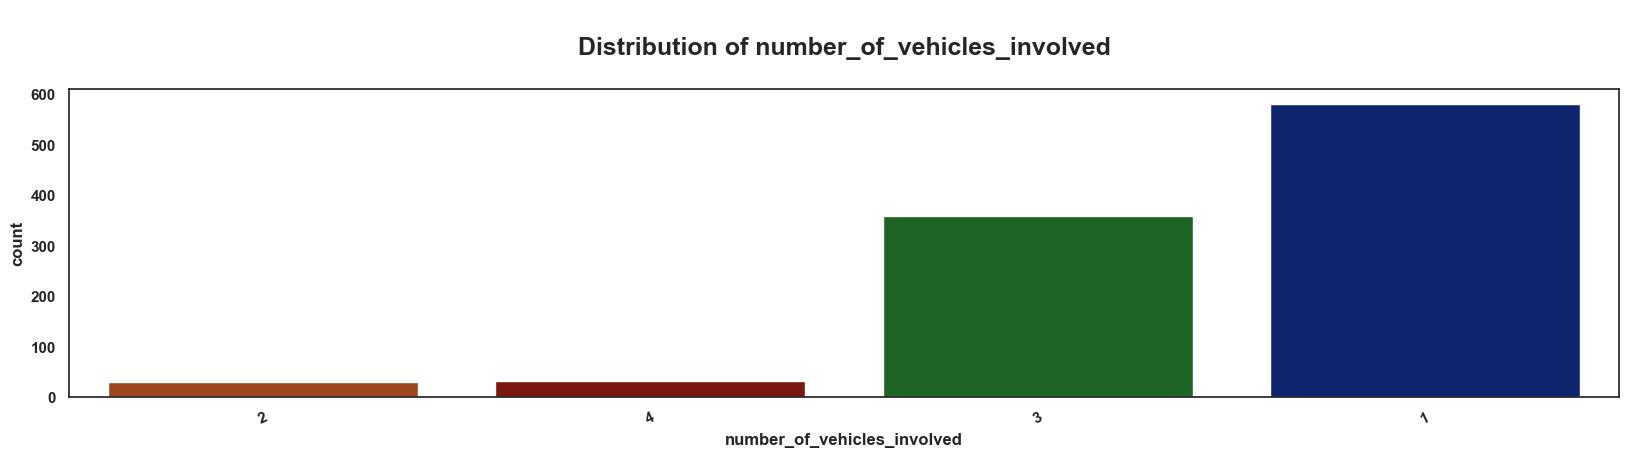

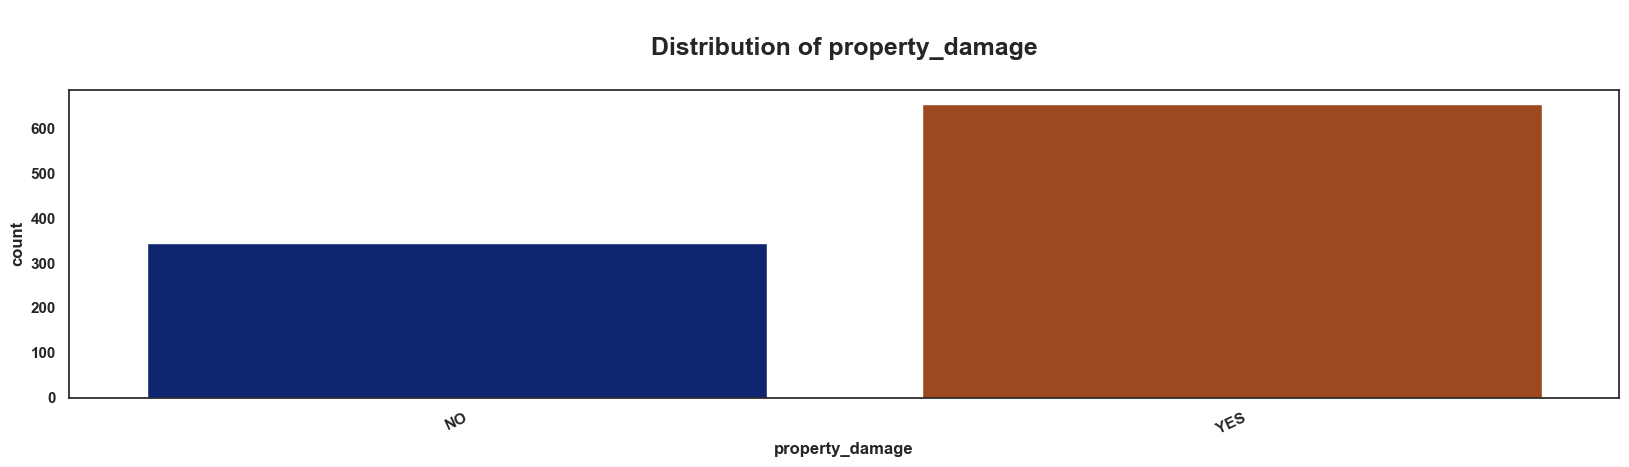

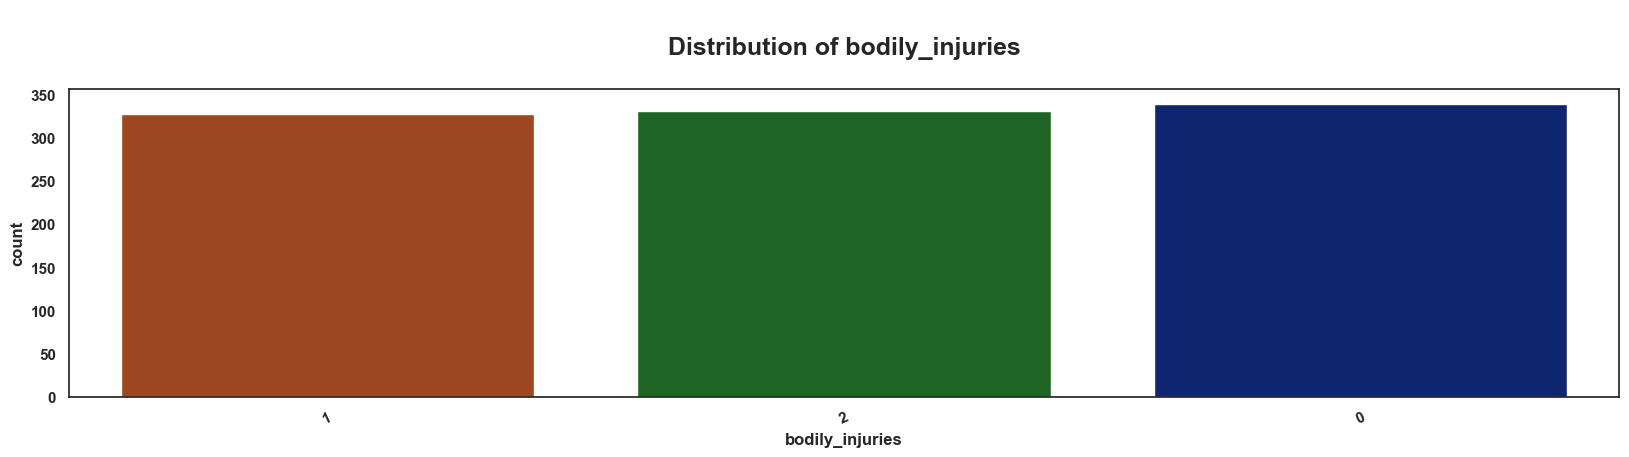

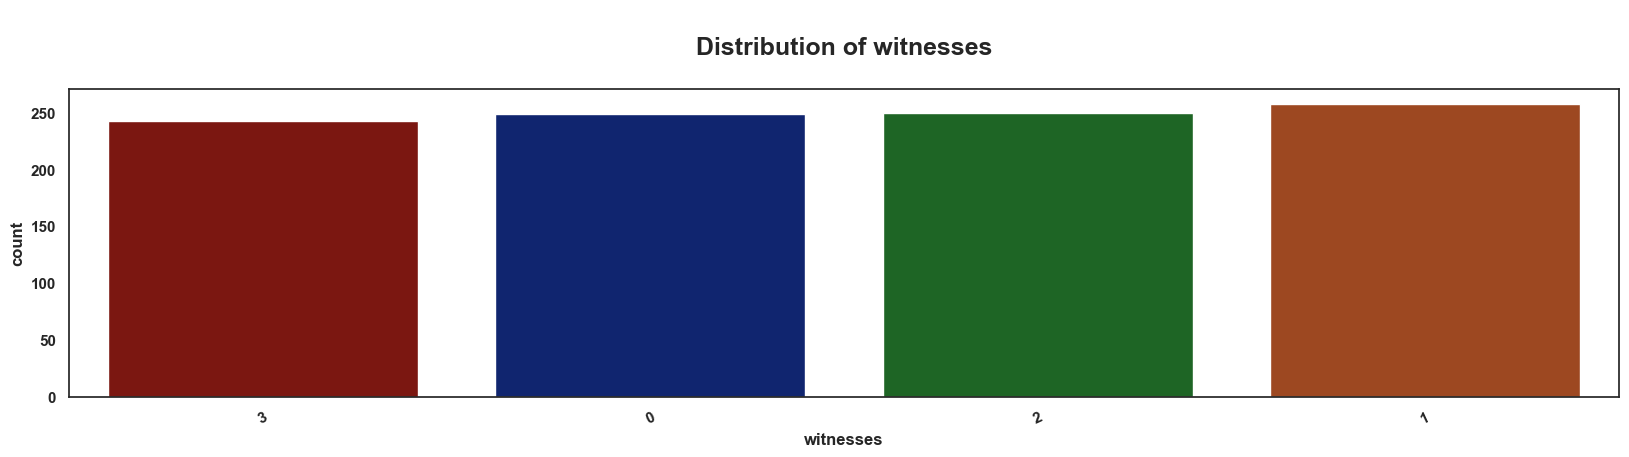

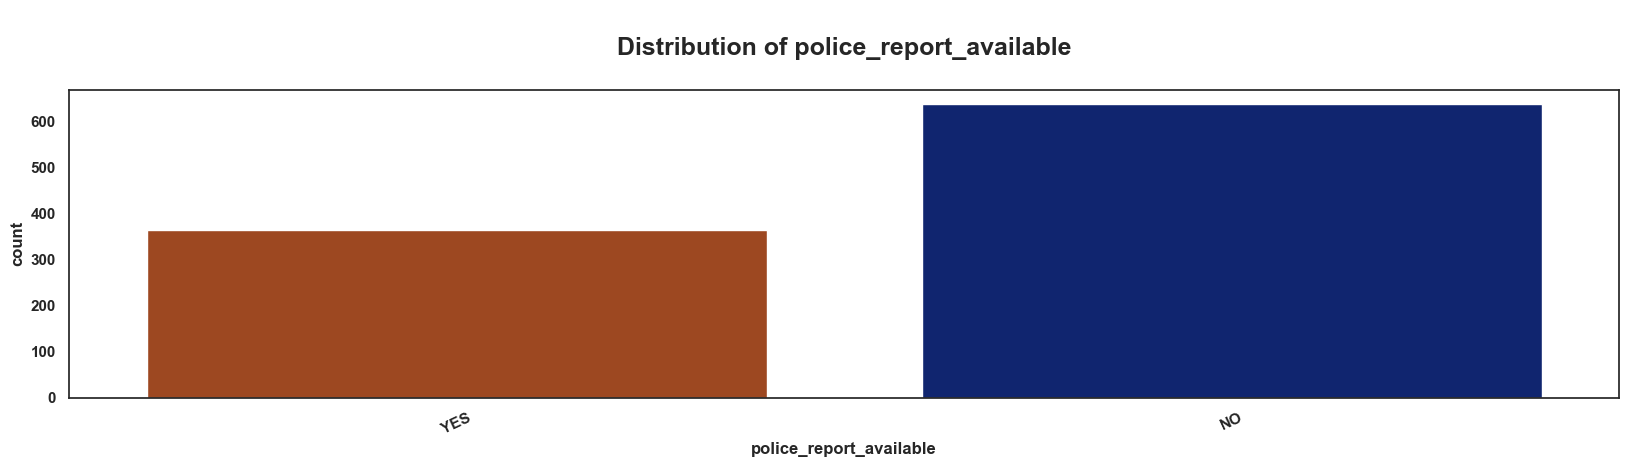

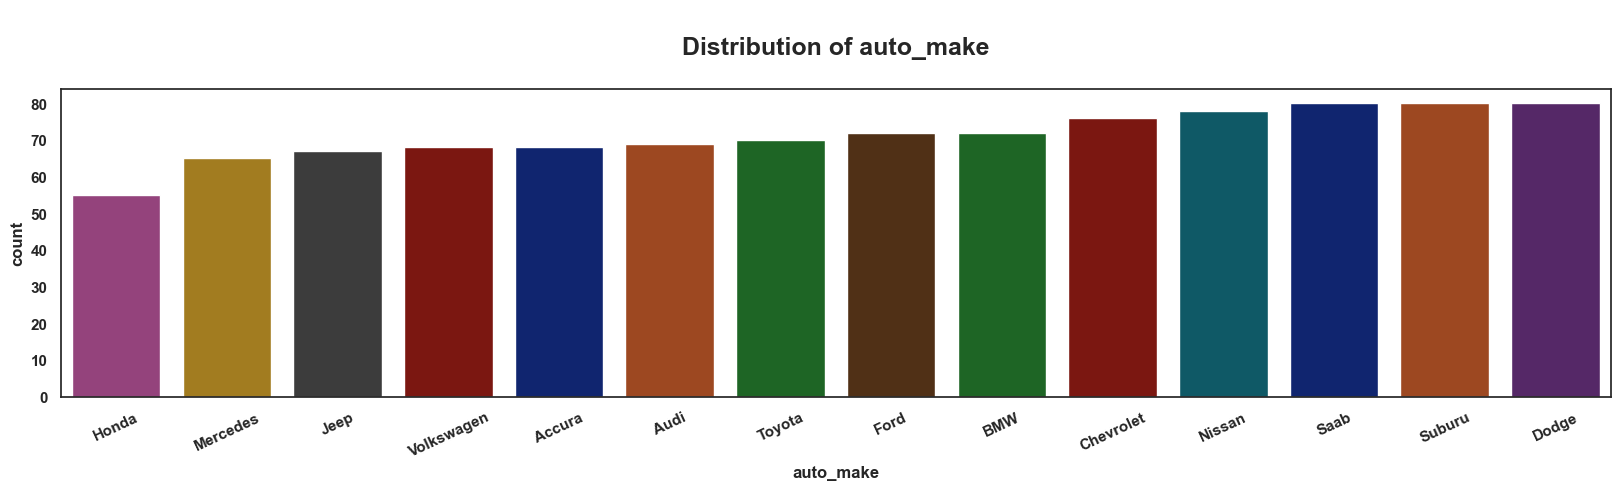

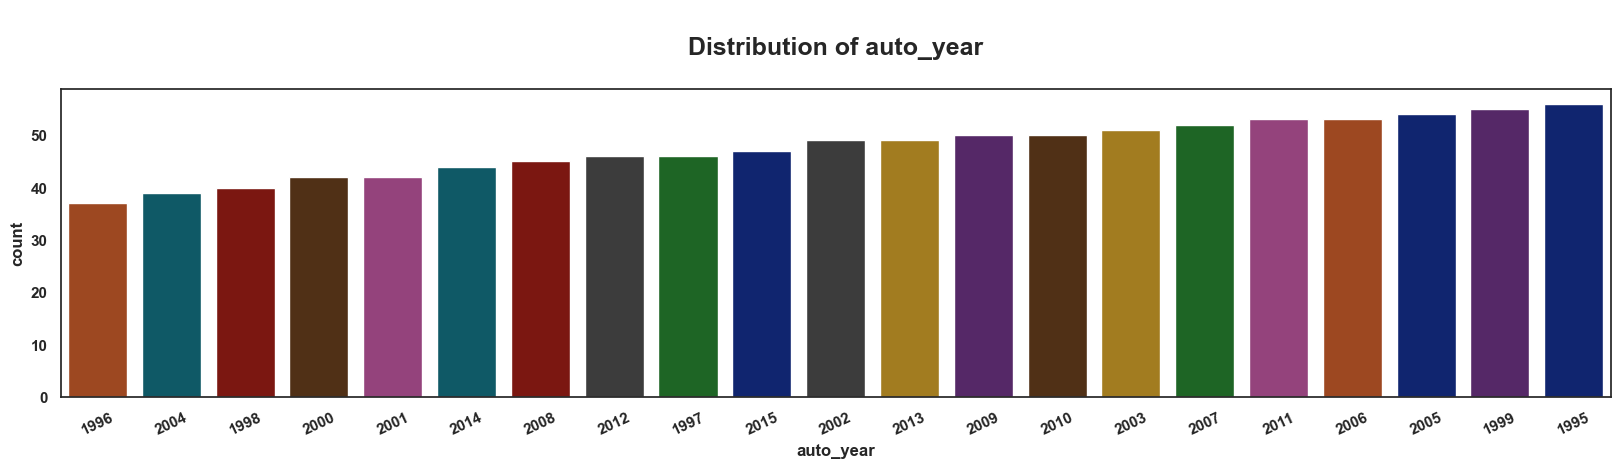

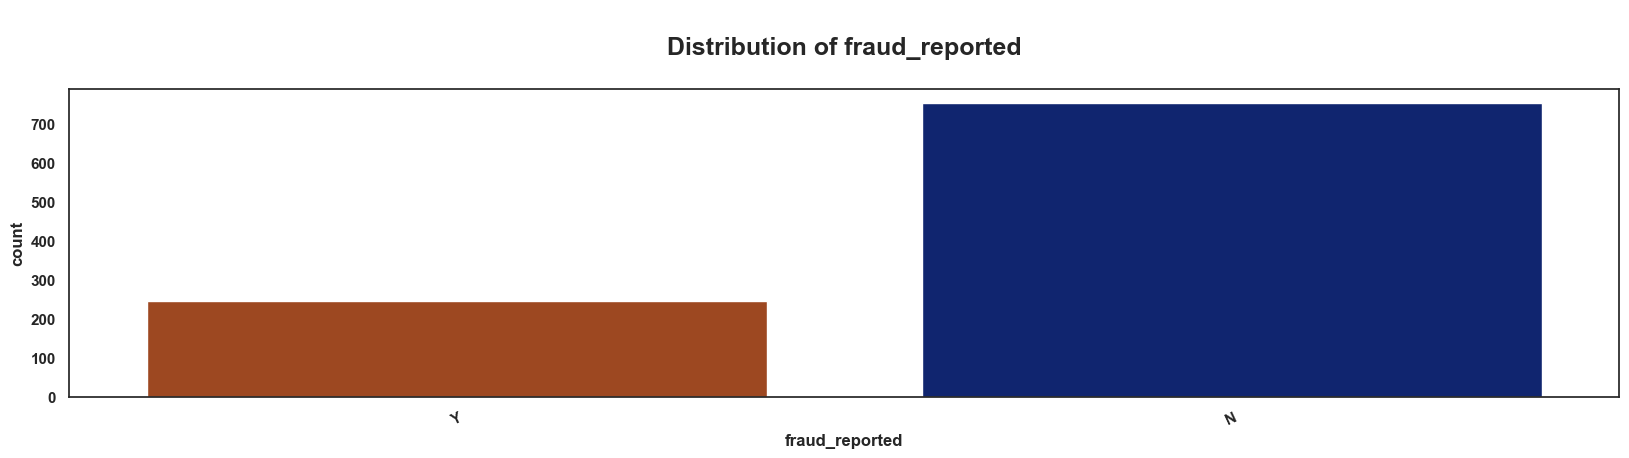

In [19]:
for i in categorical:
    plt.figure(figsize=(20, 4))
    sns.countplot(data=df, x=df[i], hue=i, order = df[i].value_counts().index.tolist()[::-1],palette='dark',legend=False)
    plt.title(f"\nDistribution of {i}\n",fontdict={'fontsize':18,'fontweight':'bold'})
    plt.xticks(rotation=25)
    plt.show()
    plt.close()

#### <span style="color:Khaki;"> Insights from Categorical Variables distribution:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Bank Accounts: -**</span>  Most people have 3 to 9 bank accounts.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Credit Cards: -**</span> Most people have 3 to 8 credit cards.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loans -**</span> Most people have 2 to 4 loans.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payment Behavior: -**</span> Most people pay the minimum due. This group is a key target for our problem statement (target people for the bank).

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Scores: -**</span> Most people have a standard credit score, likely those who pay only the minimum dues.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loan Enquiries: -**</span> The largest audience consists of people with low loan enquiries.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Age Distribution: -**</span> Most of the audience is aged between 36 and 50. There is a non-linear relationship observed, with minimal representation from those below 18 and above 50. The mid-age group constitutes the majority.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Payment Behaviour: -**</span> it has only one category so we can drop this column.

### <span style="color:Khaki;"> Relationship Numerical Variables VS Classification Target (Fraud):</span>

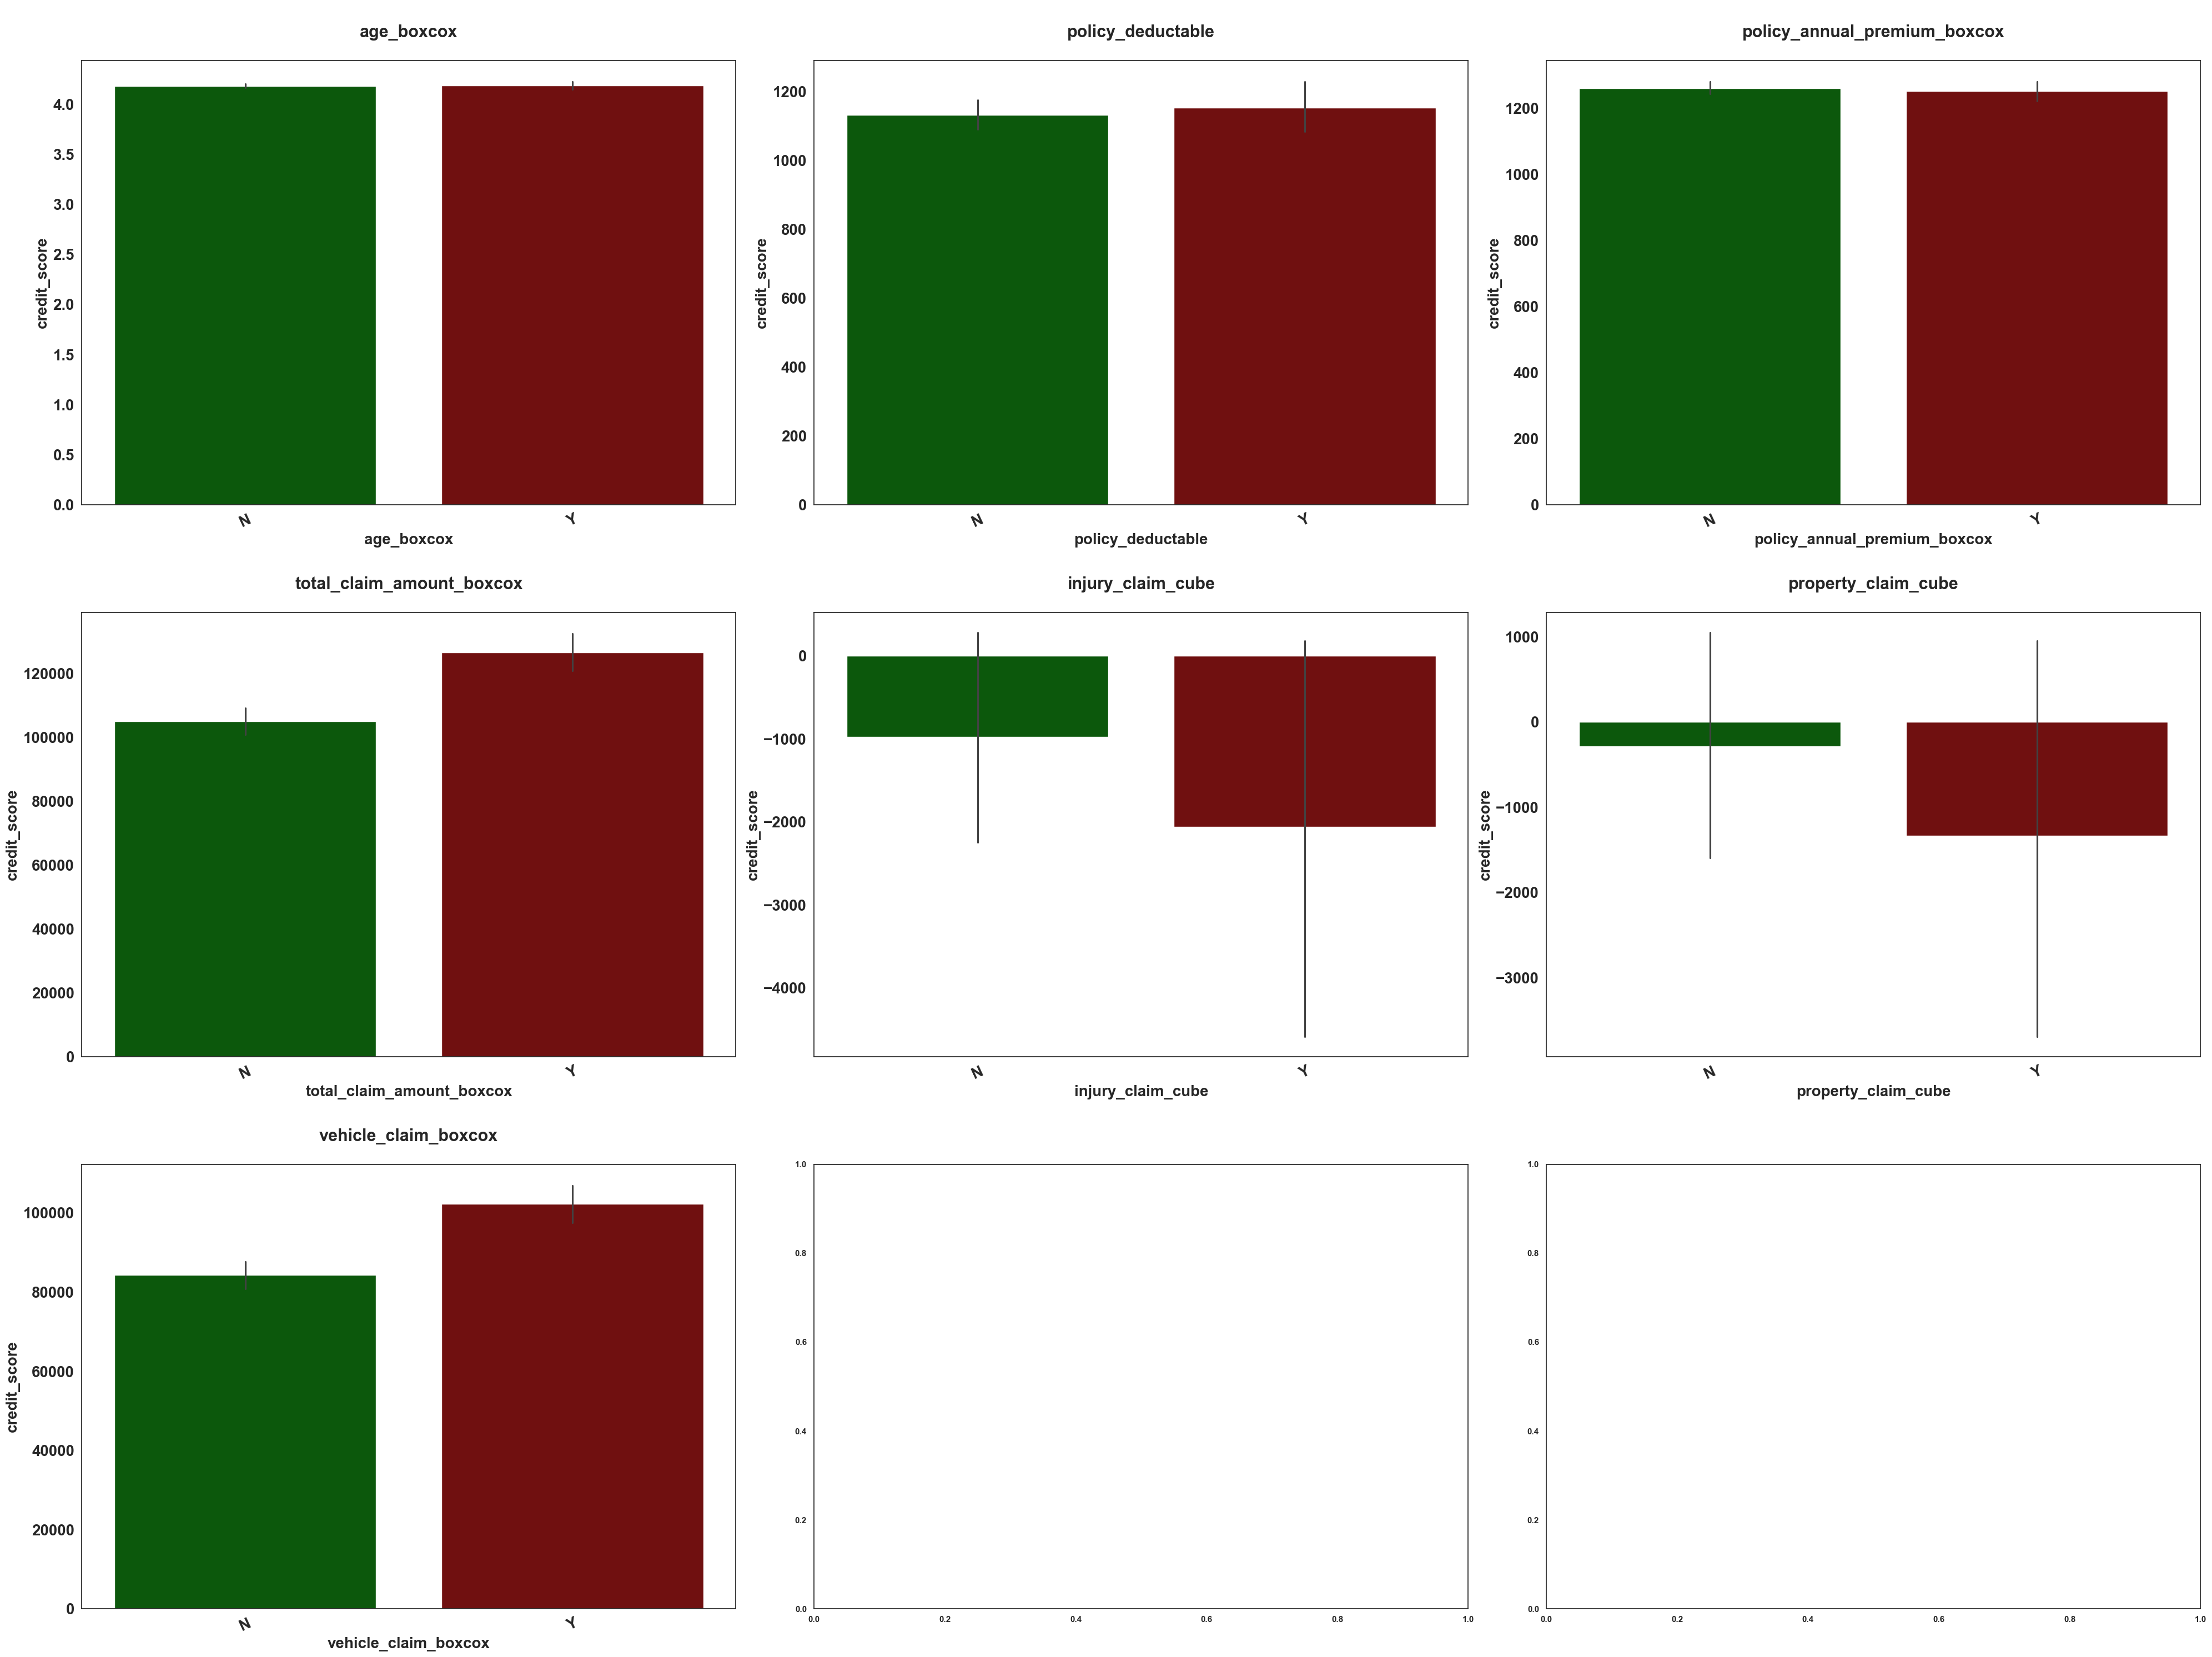

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [20]:
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil(len(continuous)/3)), figsize=(40, 30))


for i, col in enumerate(continuous):
    if i != 'fraud_reported':
        sns.barplot(data=df, y=col, x='fraud_reported', hue="fraud_reported",hue_order=['N','Y'],orient='v',palette=['DarkGreen','maroon'], legend=False,ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(col,fontdict={'fontsize':20,'fontweight':'bold'})
        axes[i//3, i%3].tick_params(axis='x', rotation=25)
        axes[i//3, i%3].set_title(f"\n{col}\n", weight='bold', fontsize=22)  # Explicitly set title font weight and size
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
        axes[i//3, i%3].set_xlabel(col, fontsize=20, weight='bold')  # Set xlabel size and weight
        axes[i//3, i%3].set_ylabel('credit_score', fontsize=20, weight='bold')  # Set ylabel size and weight
    plt.close
plt.tight_layout()
plt.show()
plt.close

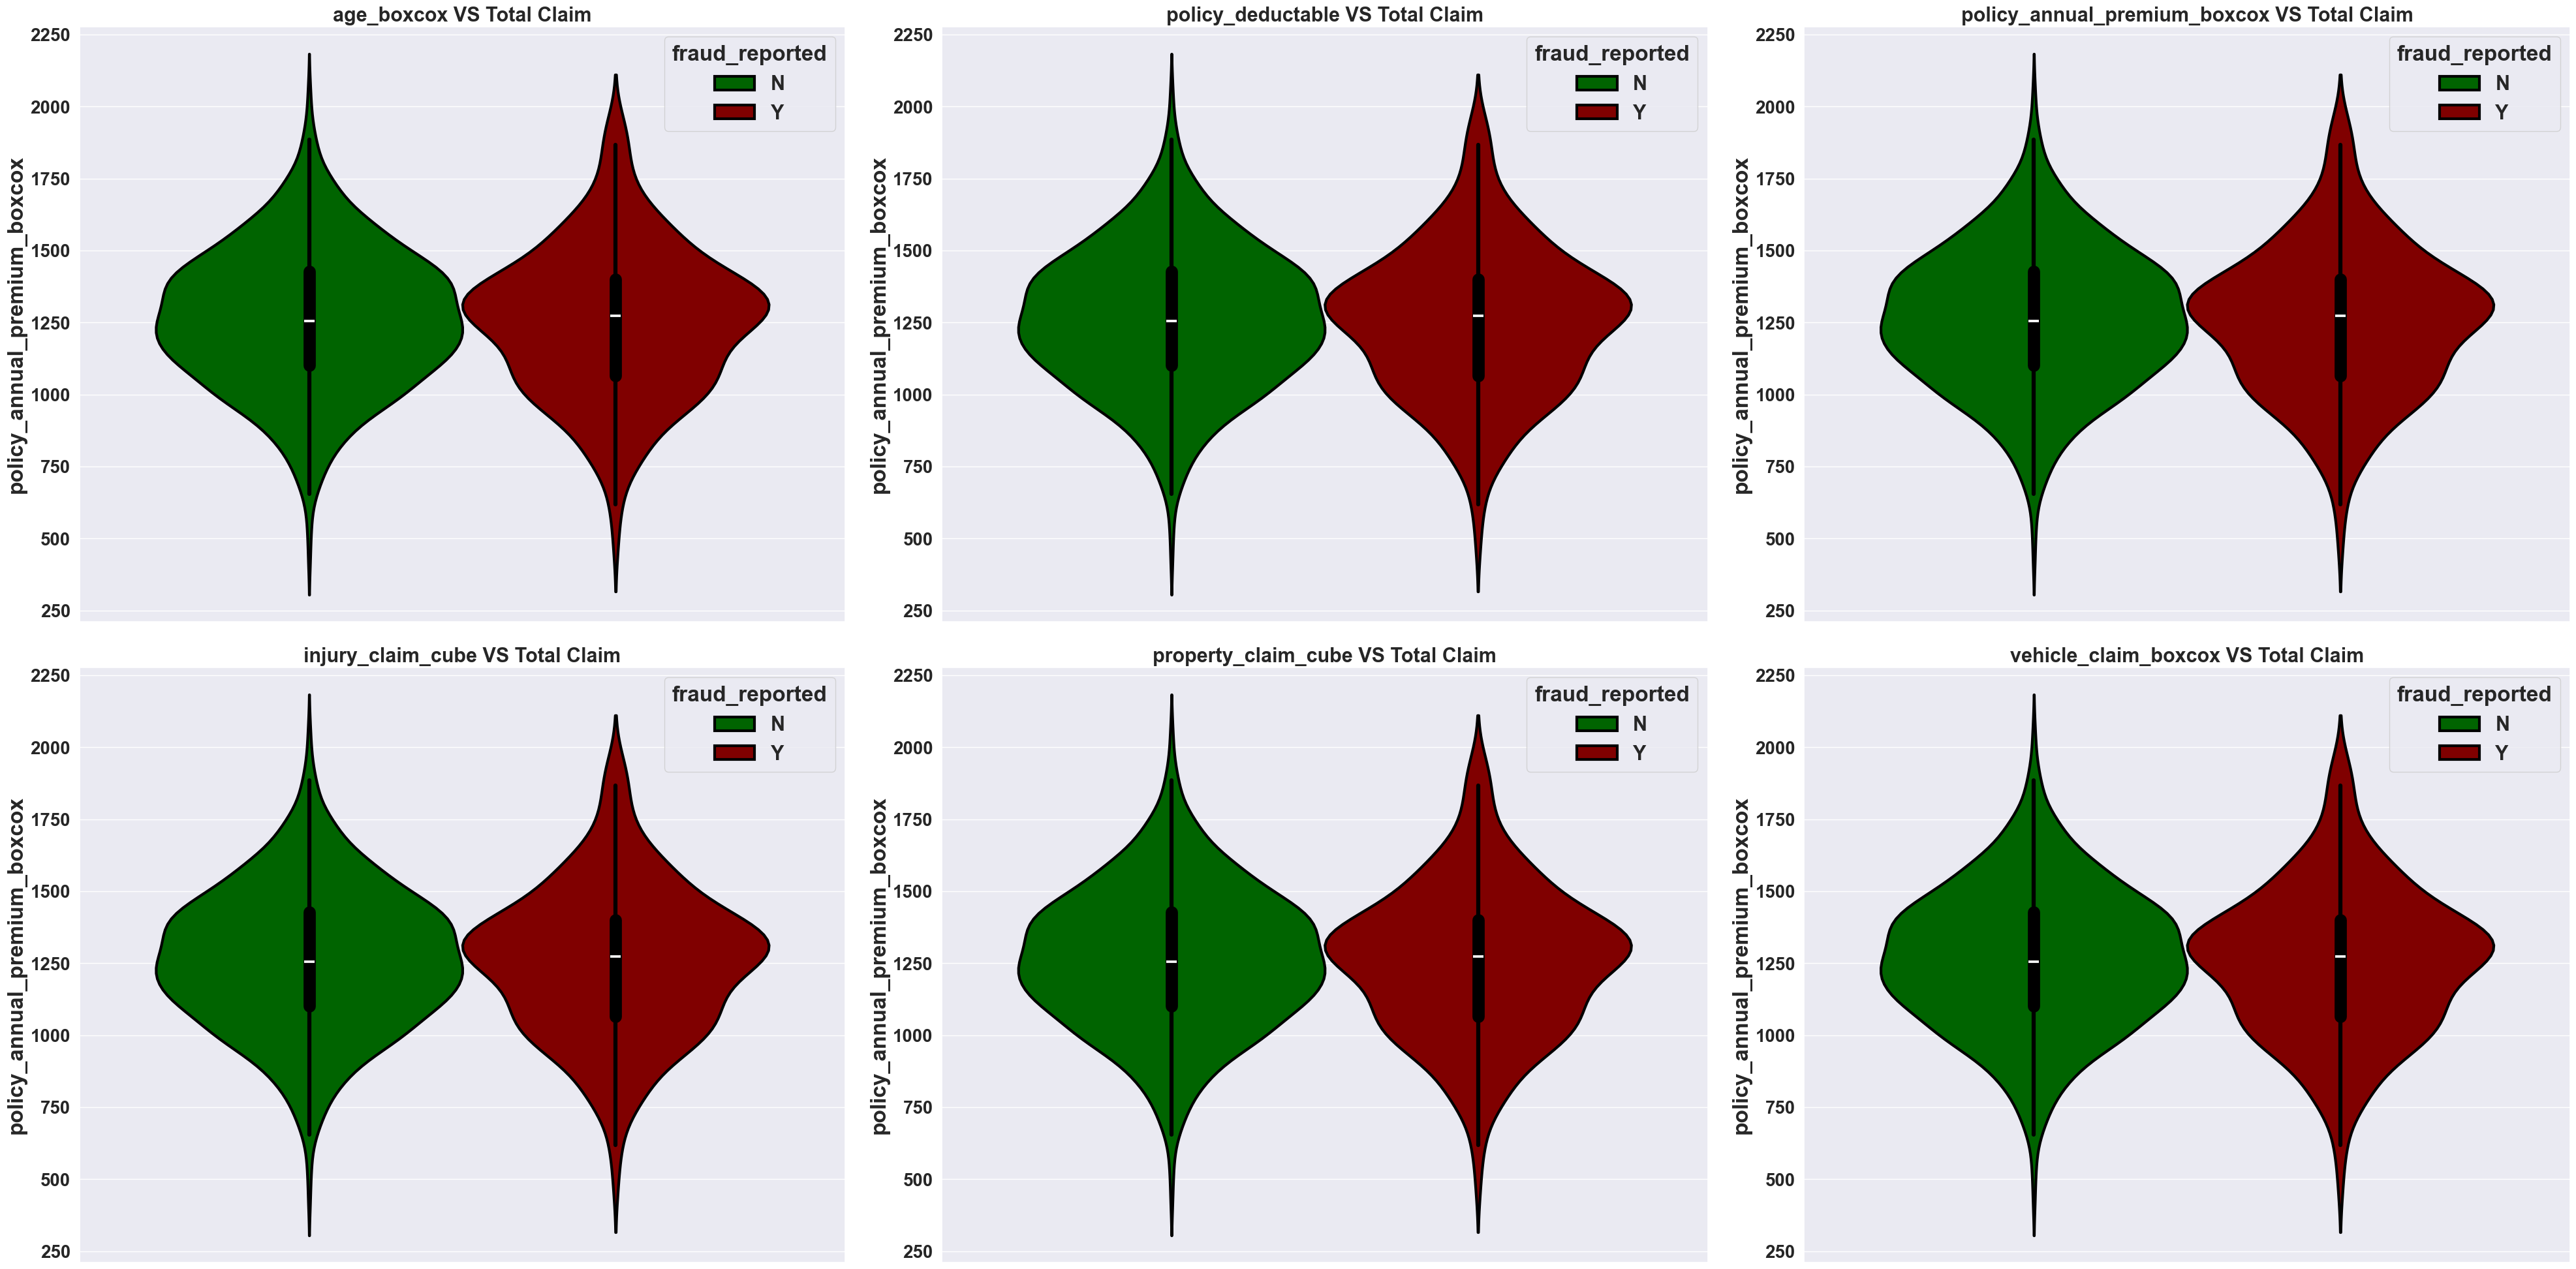

In [24]:
sns.set_theme(font_scale=2)

# continuous.remove('total_claim_amount_boxcox')


fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(continuous))/3)), figsize=(40, 20))

for i, col in enumerate(continuous):

        sns.violinplot(data=df,y='policy_annual_premium_boxcox',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'],saturation=1,
                linewidth=3,linecolor='#000000',ax=axes[i//3, i%3]).set_title(f'{col} VS Total Claim',weight='bold', fontsize=22)
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)
continuous.append('total_claim_amount_boxcox')

### <span style="color:Khaki;"> Relationship Categorical Variables VS Classification Target (Fraud):</span>

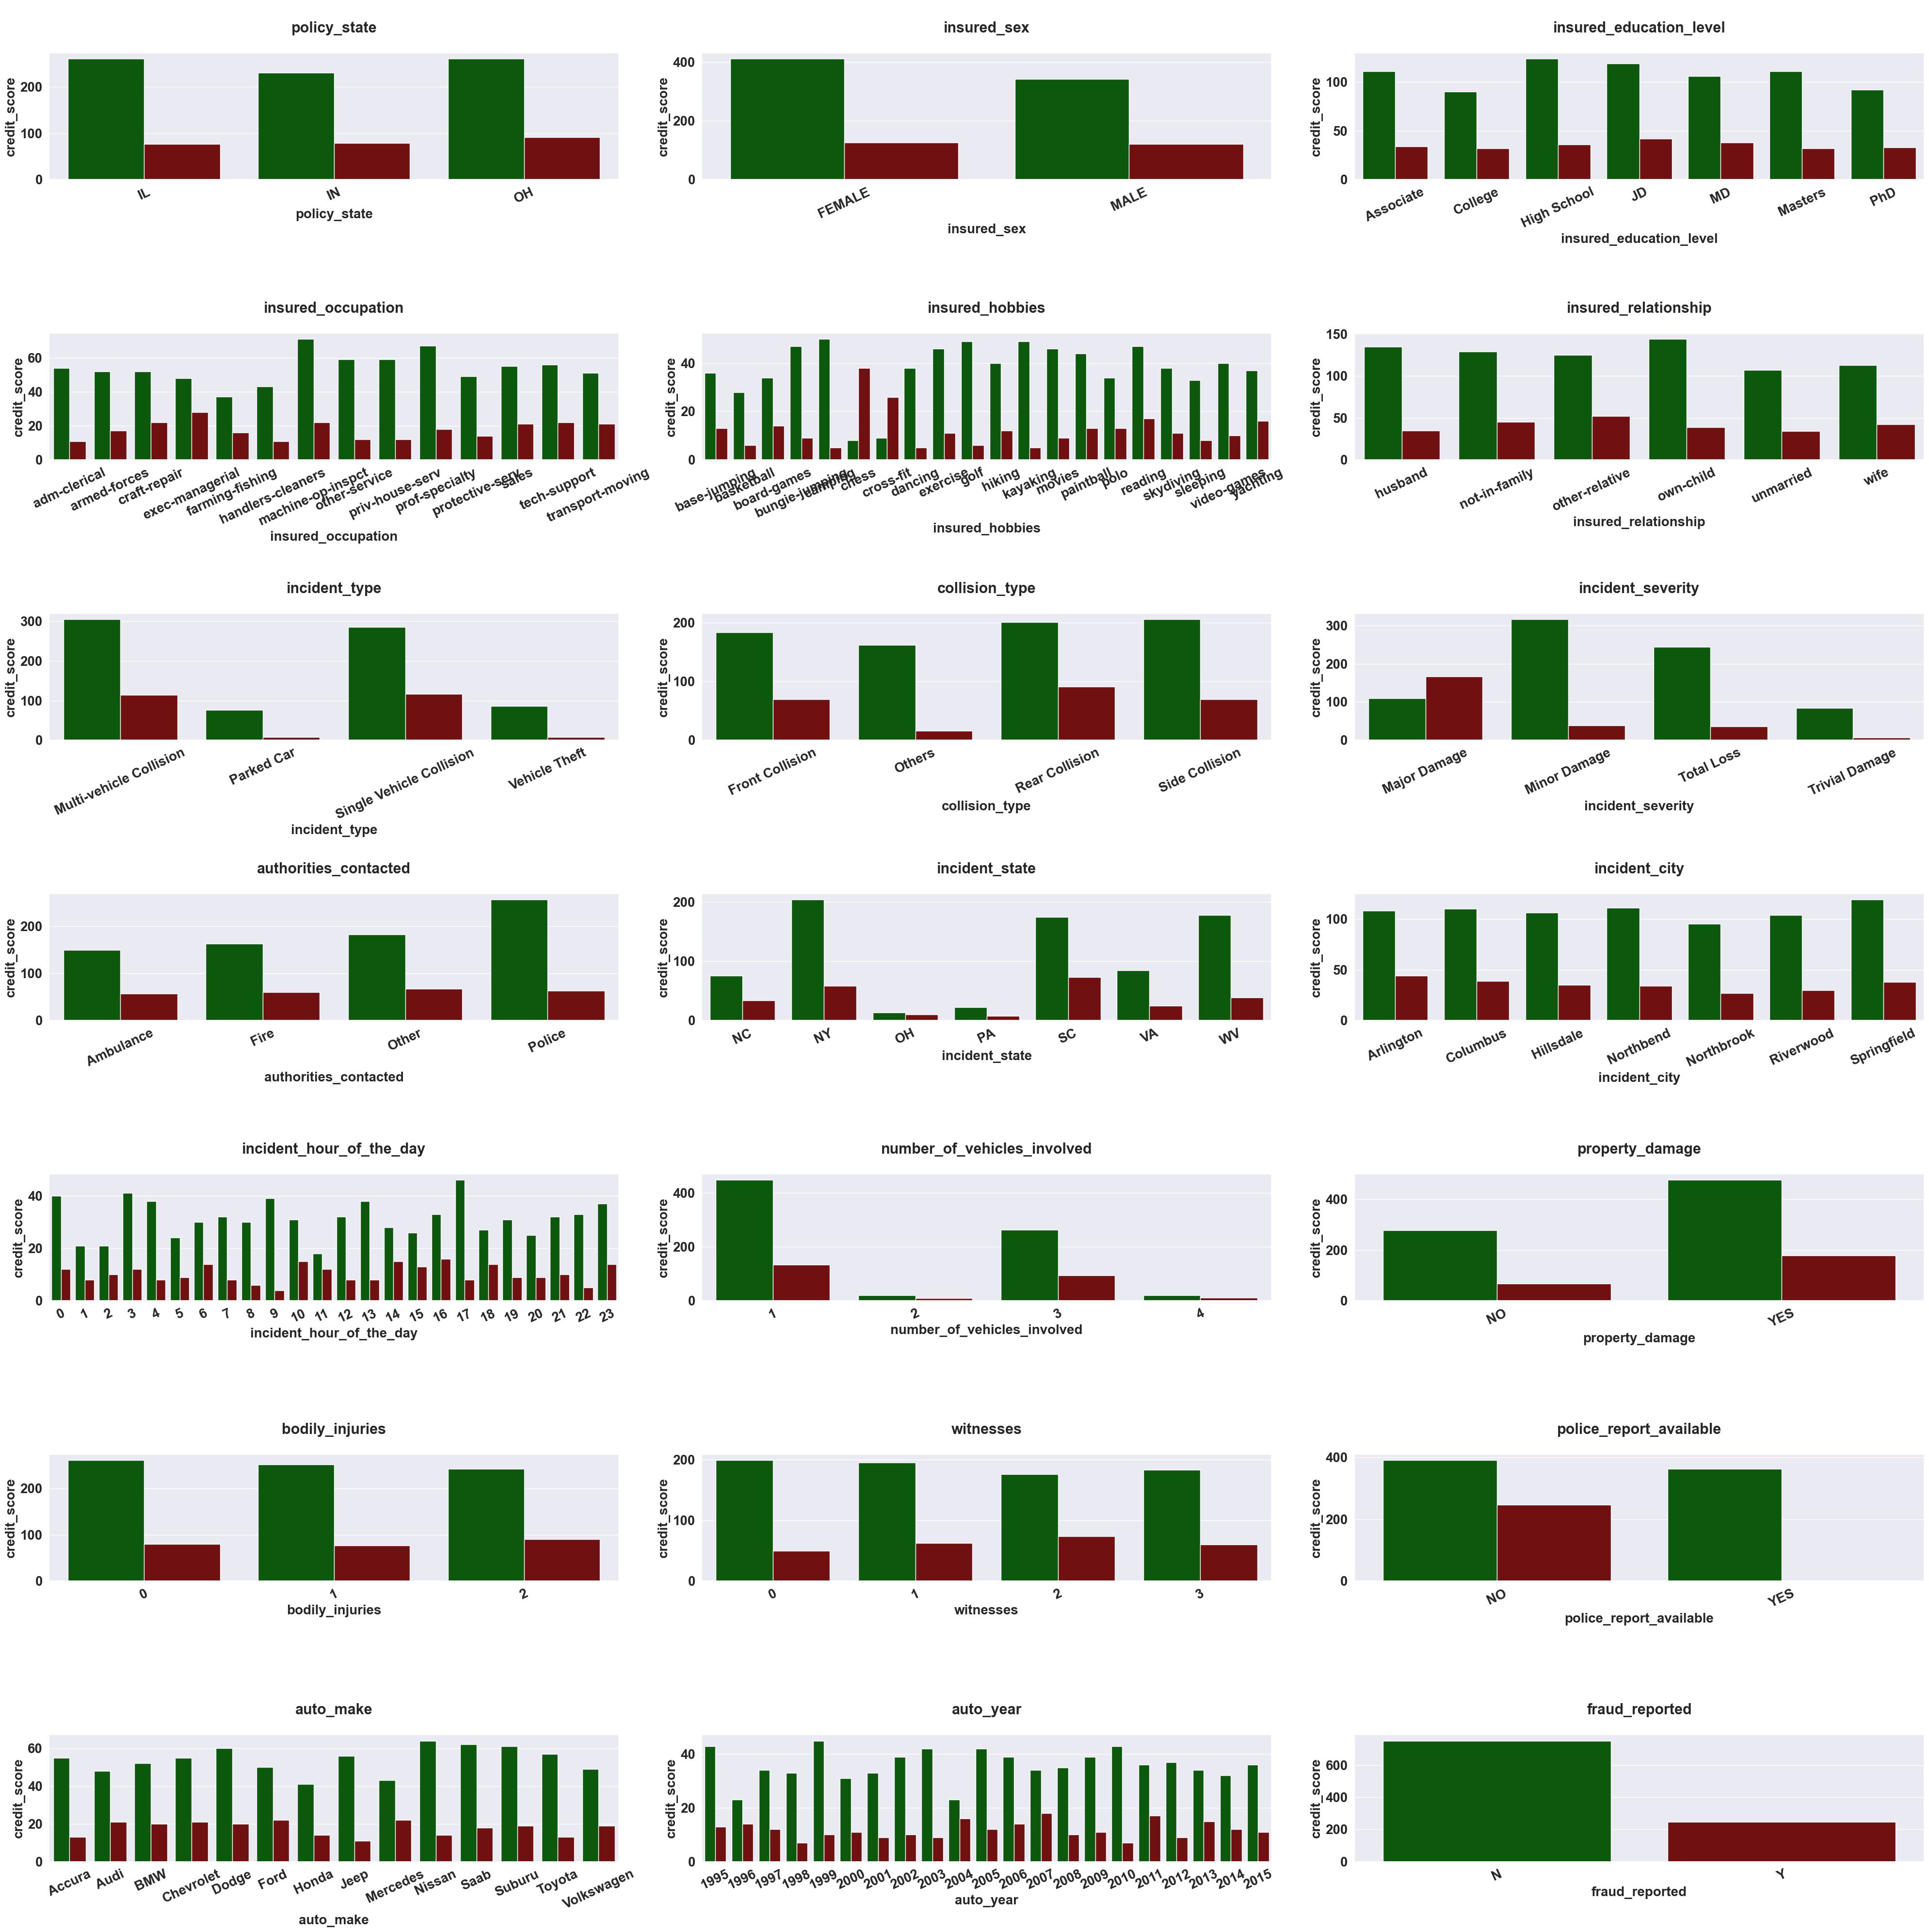

In [25]:
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil(len(categorical)/3)), figsize=(40, 40))

for i, col in enumerate(categorical):
    if i != 'fraud_reported':
        sns.countplot(data=df, x=col, hue="fraud_reported",hue_order=['N','Y'],palette=['darkgreen','maroon'], legend=False,ax=axes[i//3, i%3])
        axes[i//3, i%3].set_title(f"\n{col}\n", weight='bold', fontsize=22)  # Explicitly set title font weight and size
        axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
        axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
        axes[i//3, i%3].set_xlabel(col, fontsize=20, weight='bold')  # Set xlabel size and weight
        axes[i//3, i%3].set_ylabel('credit_score', fontsize=20, weight='bold')  # Set ylabel size and weight

plt.tight_layout()
plt.show()

### <span style="color:Khaki;"> Relationship Numerical Variables VS Regression Target (Policy Annual Premium):</span>

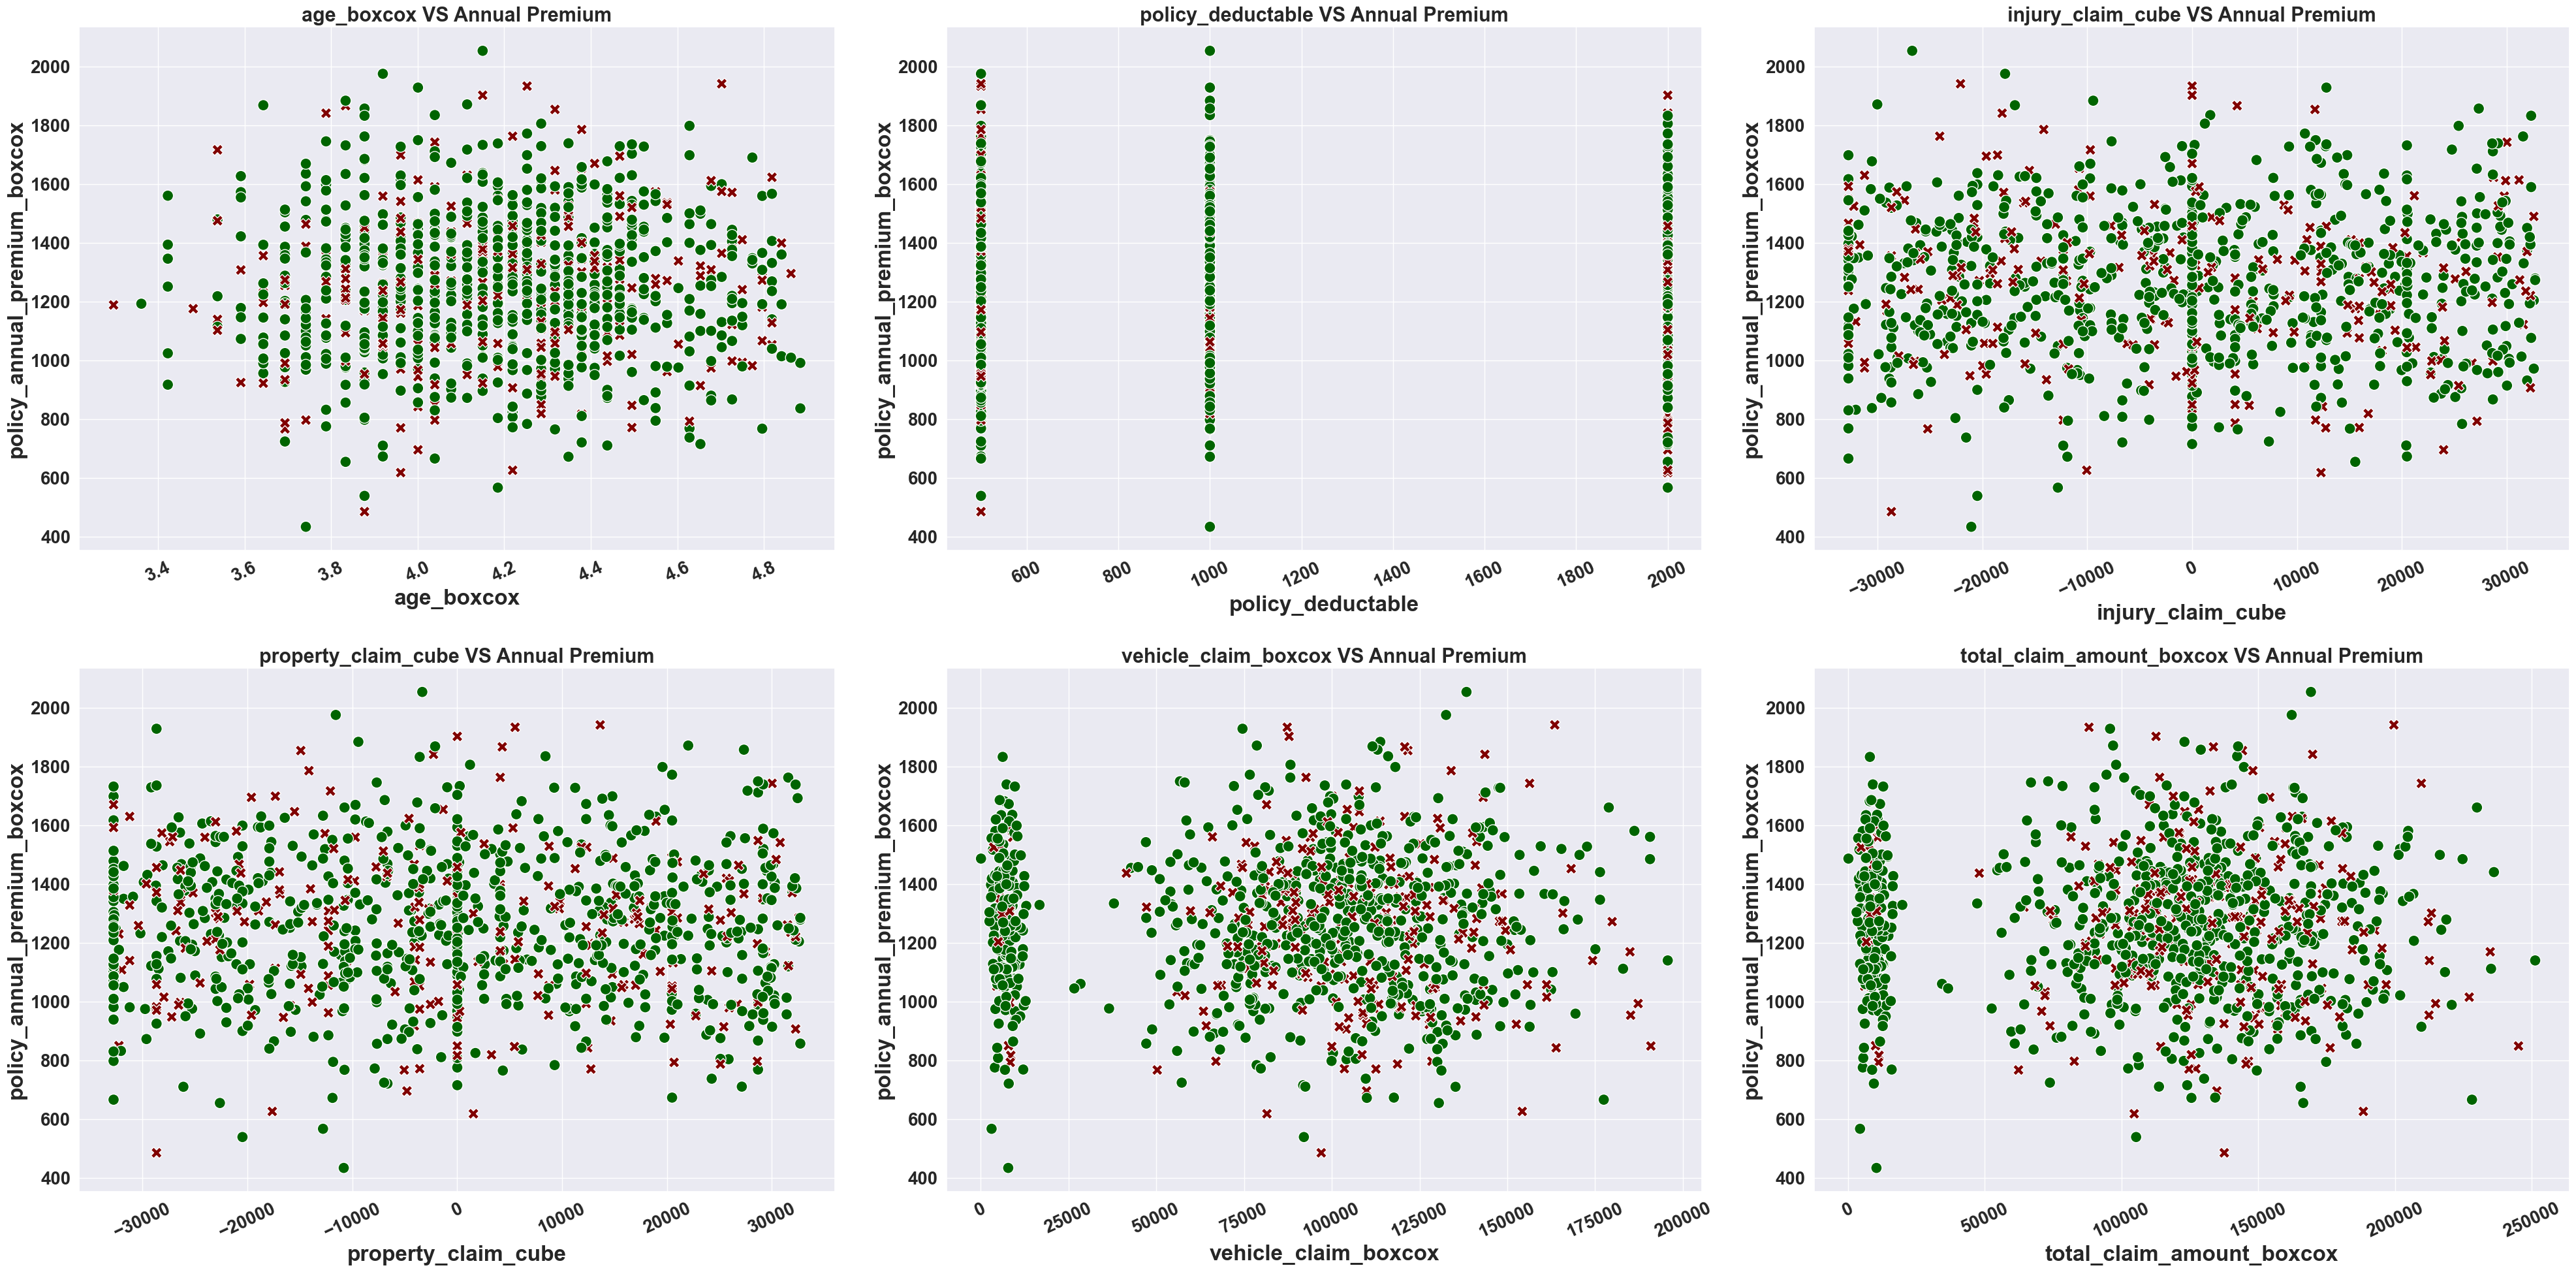

In [29]:
sns.set_theme(font_scale=2)

continuous.remove('policy_annual_premium_boxcox')
fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(continuous))/3)), figsize=(40, 20))

for i, col in enumerate(continuous):
    sns.scatterplot(data=df,x=col,y='policy_annual_premium_boxcox',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'],legend=False,style='fraud_reported',
           s=150, ax=axes[i//3, i%3]).set_title(f'{col} VS Annual Premium',weight='bold', fontsize=22)
    axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
    axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)
continuous.append('policy_annual_premium_boxcox')

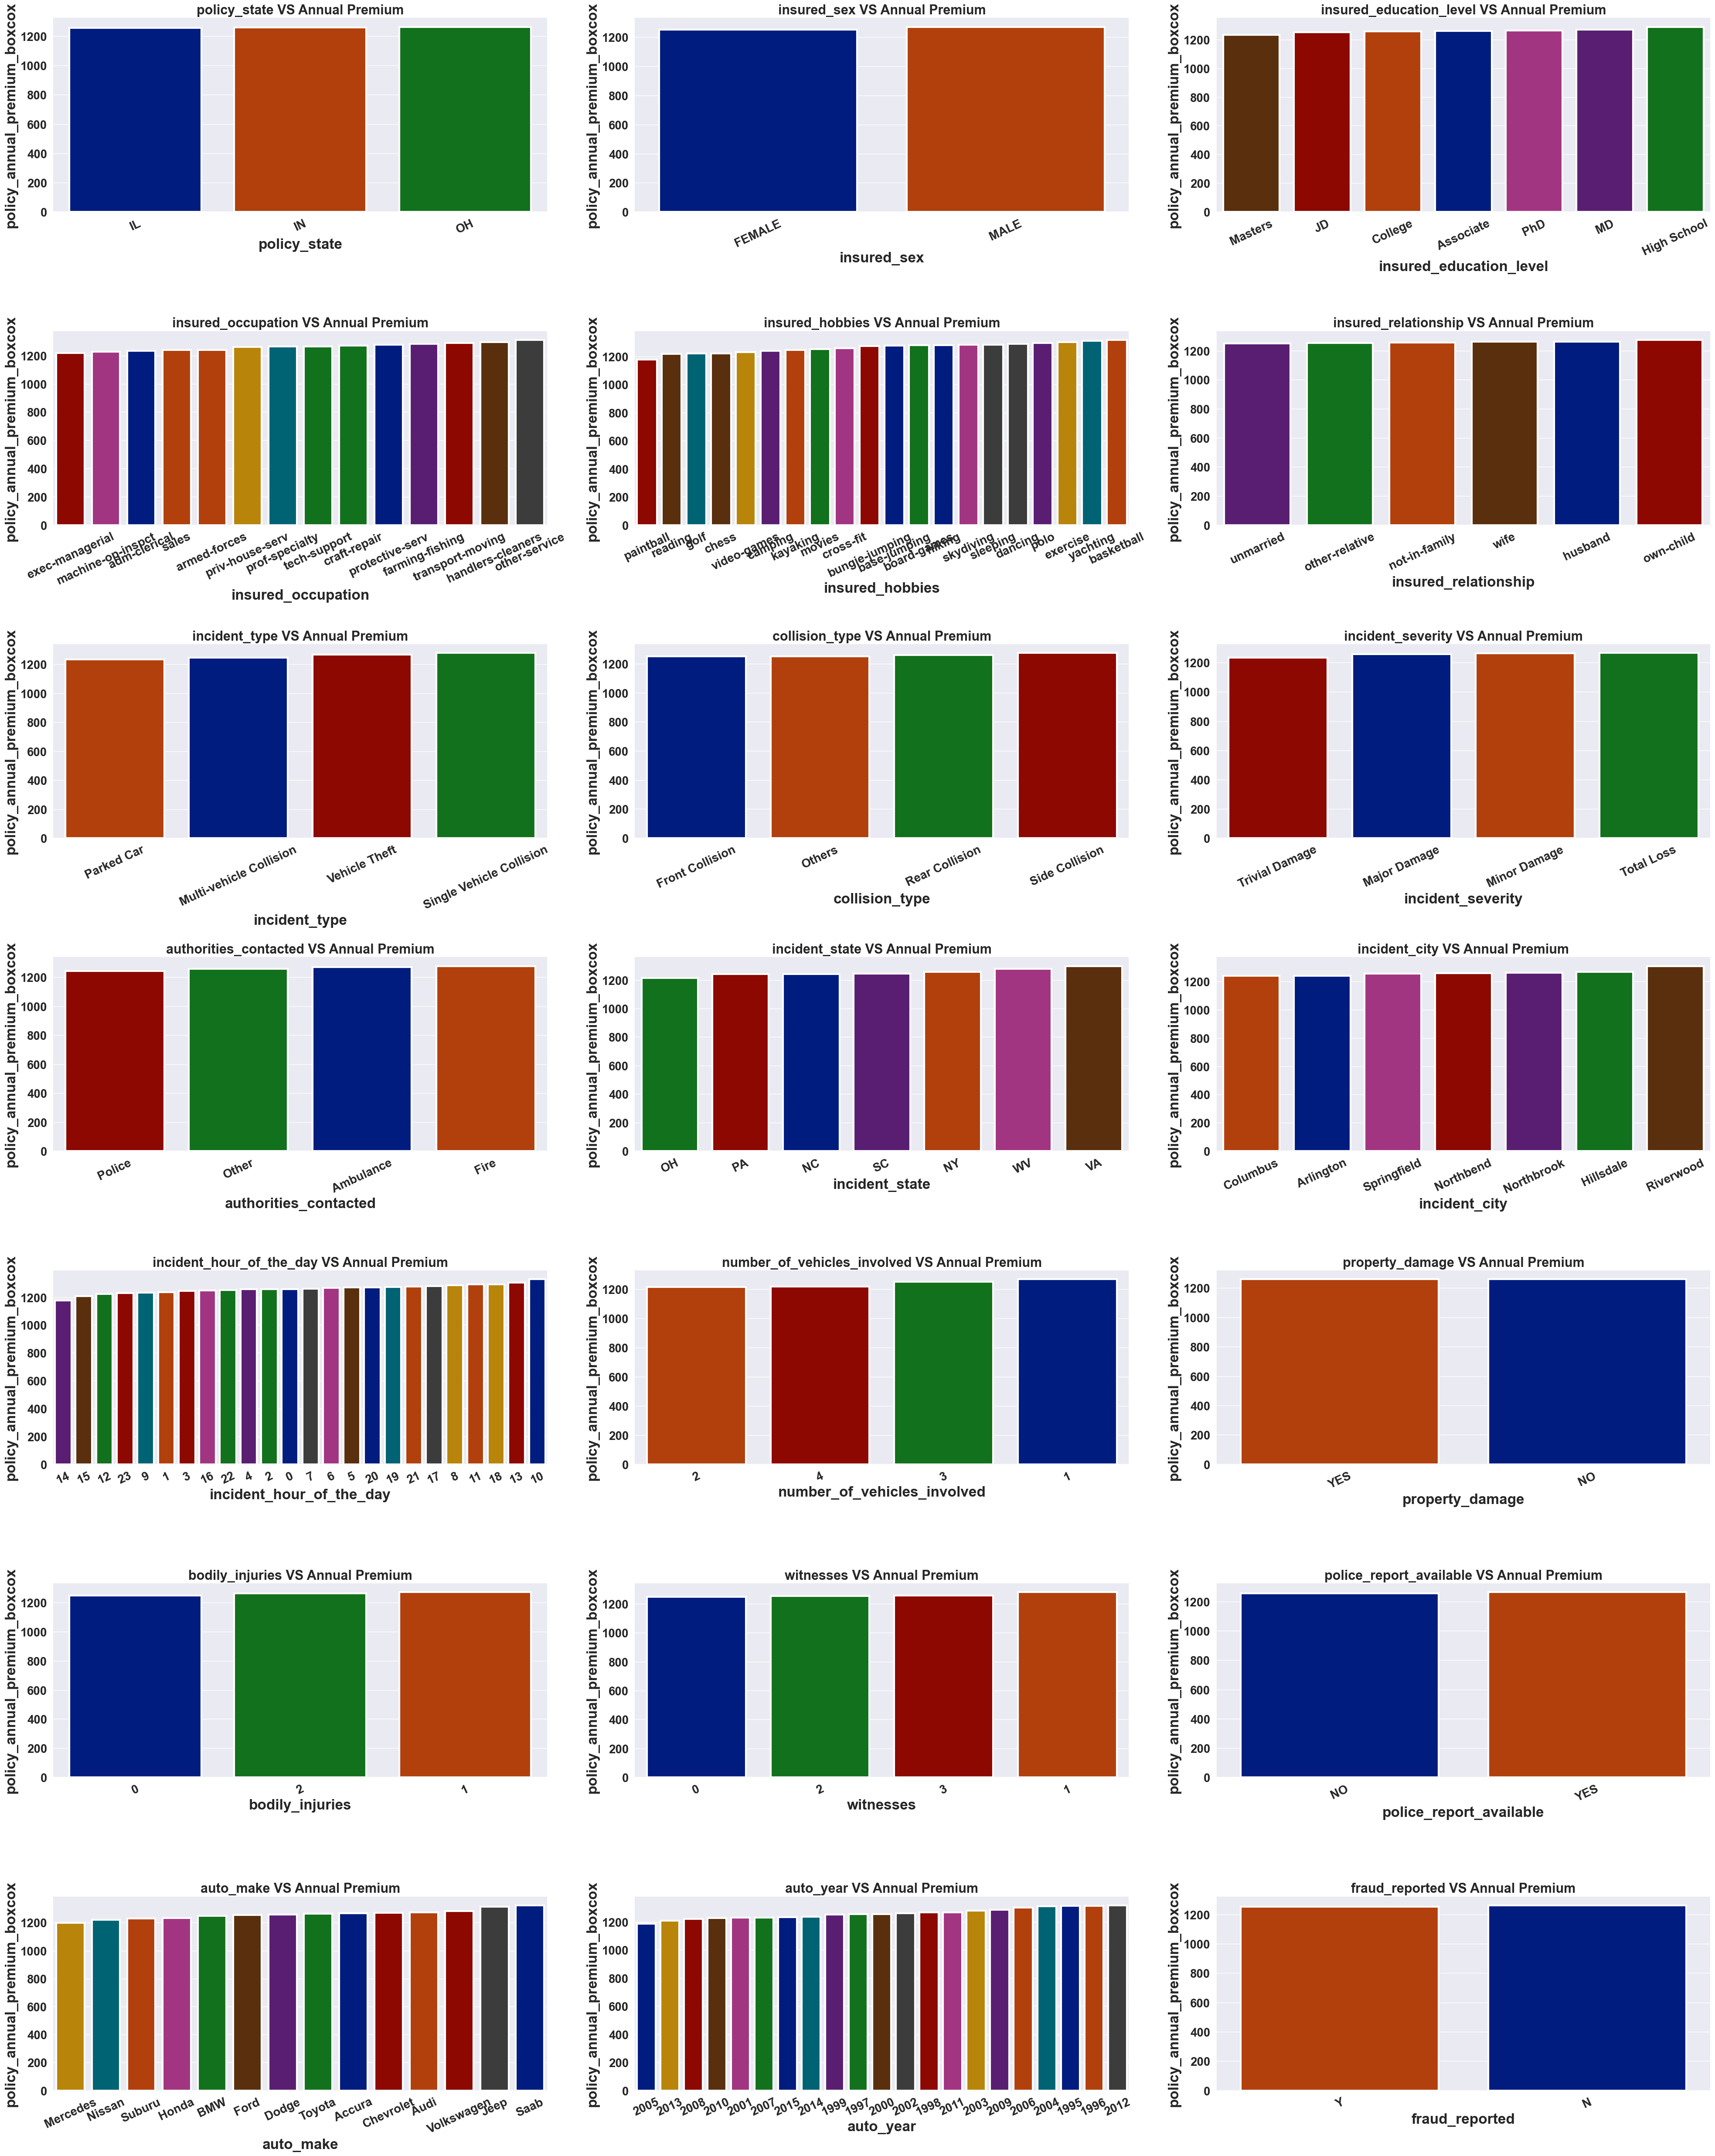

In [33]:
sns.set_theme(font_scale=2)


fig, axes = plt.subplots(ncols=3, nrows = int(np.ceil((len(categorical))/3)), figsize=(40, 50))

for i, col in enumerate(categorical):
    dff = df.groupby(col,observed=False,as_index=True)['policy_annual_premium_boxcox'].mean().reset_index().sort_values('policy_annual_premium_boxcox')

    sns.barplot(data=dff,x=col,y='policy_annual_premium_boxcox',hue=col,palette='dark',order=dff[col],saturation=1,legend=False,
            linewidth=3,ax=axes[i//3, i%3]).set_title(f'{col} VS Annual Premium',weight='bold', fontsize=22)
    axes[i//3, i%3].tick_params(axis='x', rotation=25, labelsize=20)  # Set xtick label size
    axes[i//3, i%3].tick_params(axis='y', labelsize=20)  # Set ytick label size
    
plt.tight_layout()
plt.show()
plt.close
sns.set_theme(font_scale=1)


#### <span style="color:Khaki;"> Insights from Continuous Variables in relation with Credit Score:</span>

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Income: -**</span>  Higher income is generally associated with better credit scores, while lower income tends to be associated with poorer credit scores.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Outstanding Debt: -**</span> Individuals with lower outstanding debt typically have better credit scores compared to those with higher outstanding debt.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization -**</span> Higher credit utilization is generally linked to higher credit scores, while lower credit utilization tends to be associated with lower credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit History: -**</span> A longer credit history is often associated with better credit scores, while a shorter credit history tends to be associated with poorer credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Total EMI per Month: -**</span> The relationship between total EMI per month and credit score seems complex and might be influenced by income level. Higher EMIs are not necessarily indicative of better or worse credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Investment: -**</span> Individuals with higher investment amounts tend to have better credit scores compared to those with lower investment amounts.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Monthly Balance: -**</span> Maintaining a higher monthly balance is generally associated with better credit scores, while lower balances tend to be associated with poorer credit scores.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization Ratio: -**</span> This seems to have a strong positive correlation with credit score.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Debt Income Ratio: -**</span> A lower debt-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Loan Income Ratio: -**</span> A lower loan-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Interest Rate: -**</span>  While the relationship is less clear, there might be a slight tendency for lower interest rates to be associated with better credit scores.

   - <span style="color: Tomato;font-fa mily:calibri;font-size:130%">**Delayed Payment Ratio: -**</span> This seems to have a strong negative correlation with credit score.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Investment to Income Ratio -**</span> A higher investment-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Credit Utilization to Income Ratio: -**</span> A lower credit utilization-to-income ratio is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Savings Rate: -**</span> A higher savings rate is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Disposable Income: -**</span> A higher disposable income is generally associated with better credit scores.

   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Debt Paytime: -**</span> A shorter debt pay time is generally associated with better credit scores.
   
   - <span style="color: Tomato;font-family:calibri;font-size:130%">**Reliable Payment: -**</span> A higher reliable payment score is generally associated with better credit scores.

### <span style="color:Khaki;"> Credit Scores Based on Annual Income:</span>

In [12]:
df.columns

Index(['months_as_customer', 'age', 'policy_bind_date', 'policy_state',
       'policy_deductable', 'policy_annual_premium', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_year', 'fraud_reported'],
      dtype='object')

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

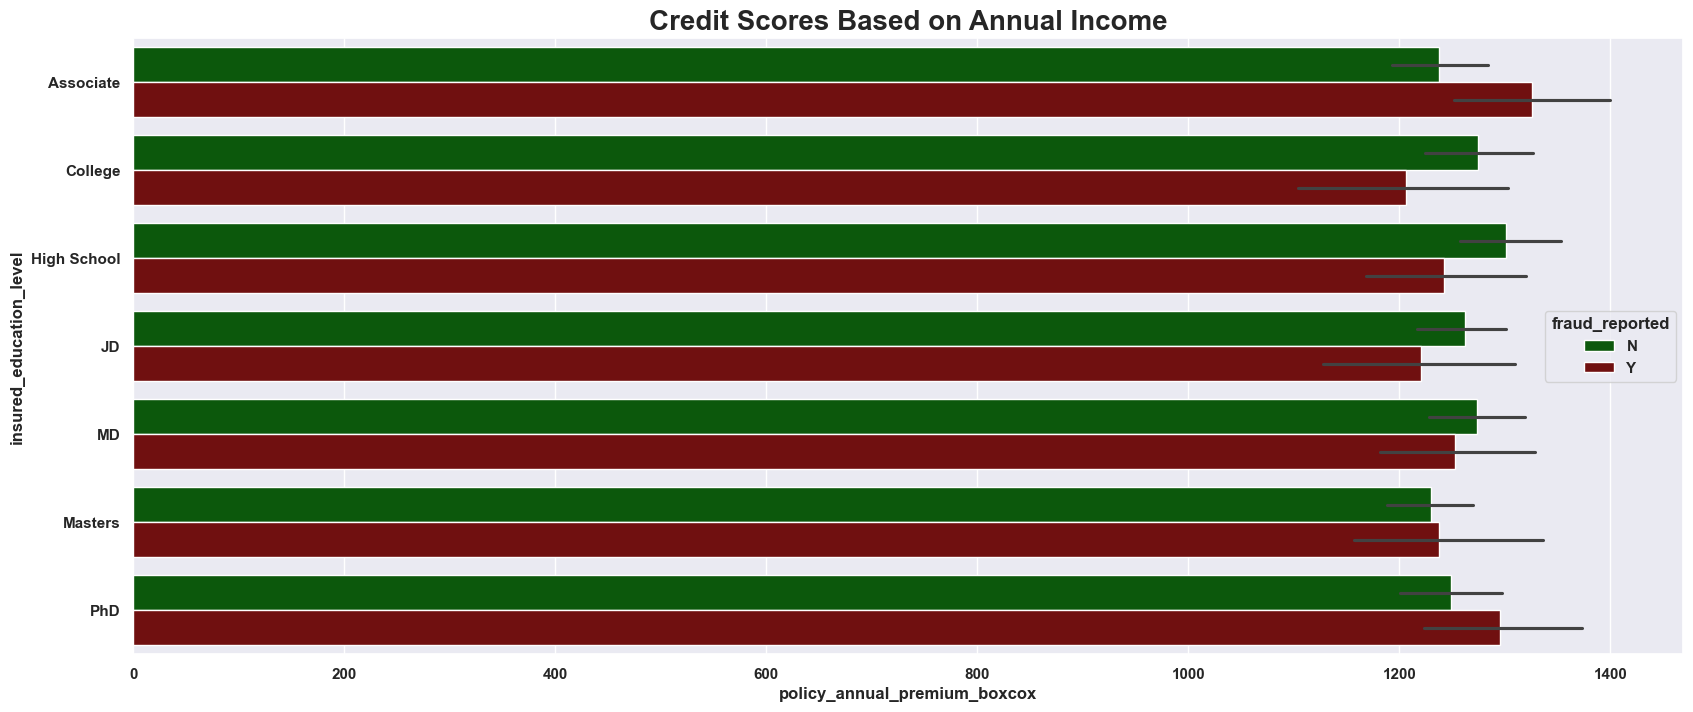

In [34]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium_boxcox', y='insured_education_level',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

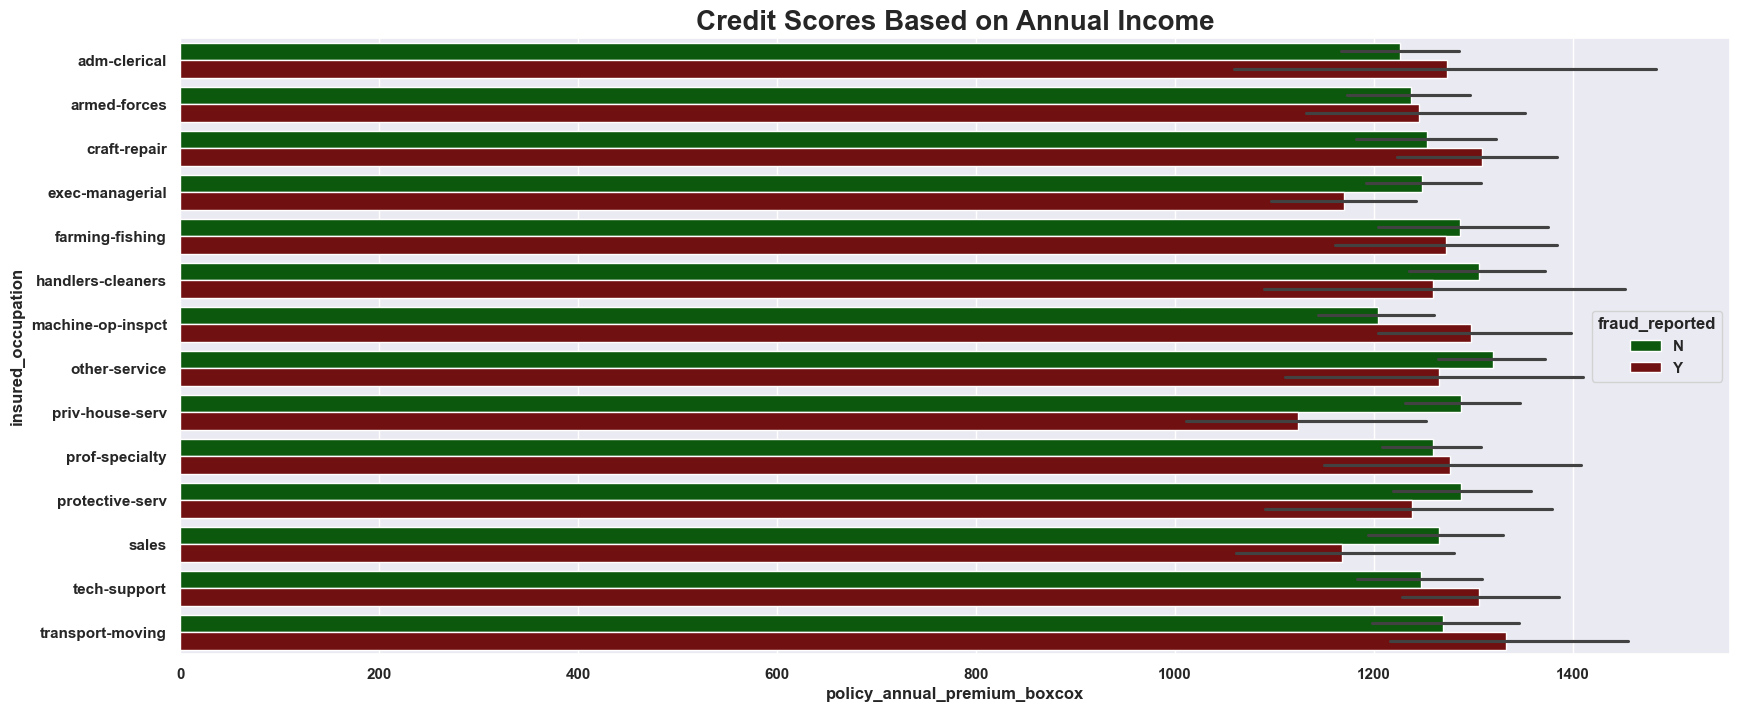

In [36]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium_boxcox', y='insured_occupation',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

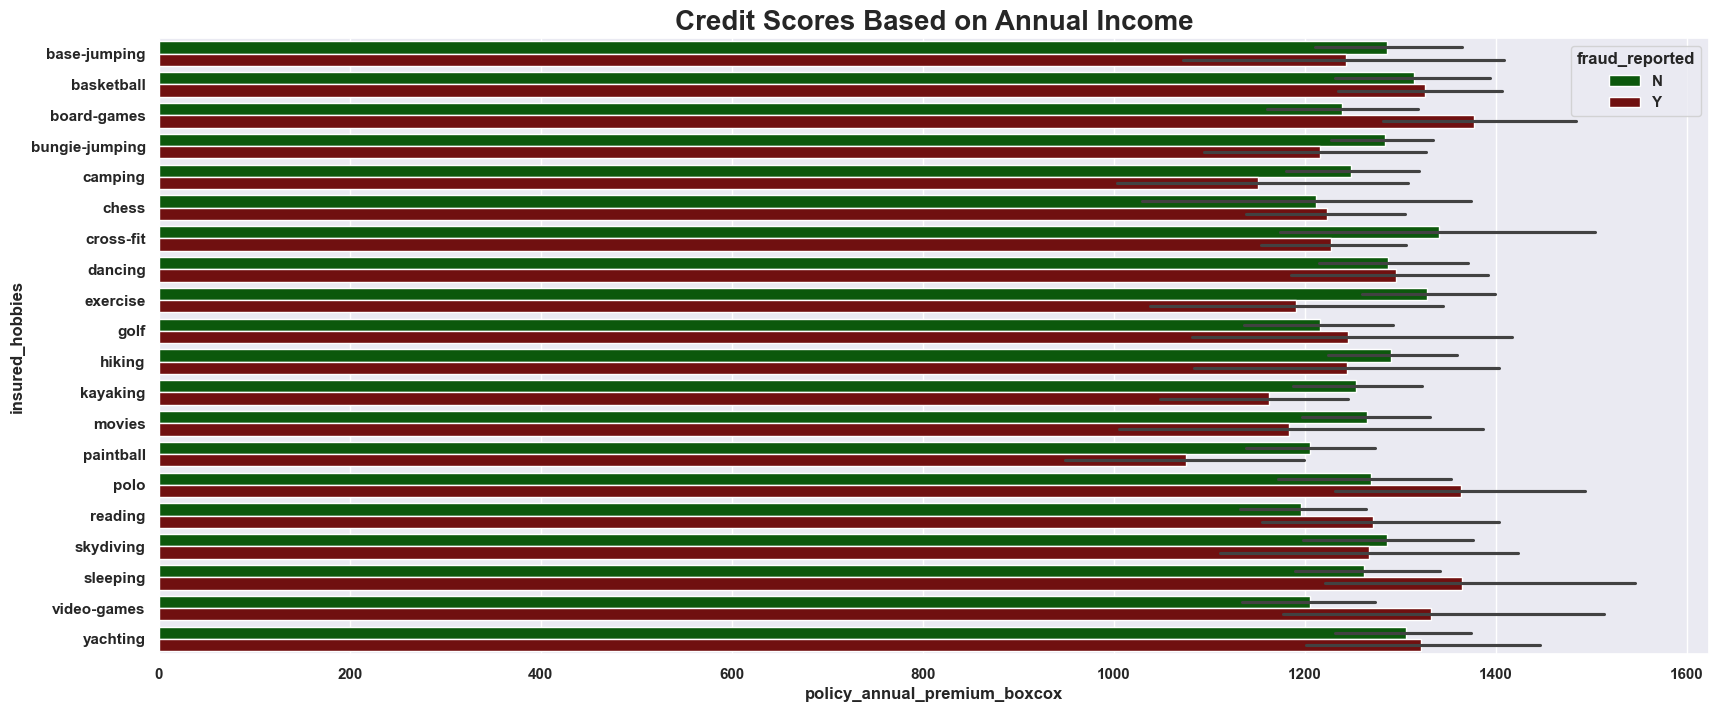

In [37]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium_boxcox', y='insured_hobbies',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

Text(0.5, 1.0, 'Credit Scores Based on Annual Income')

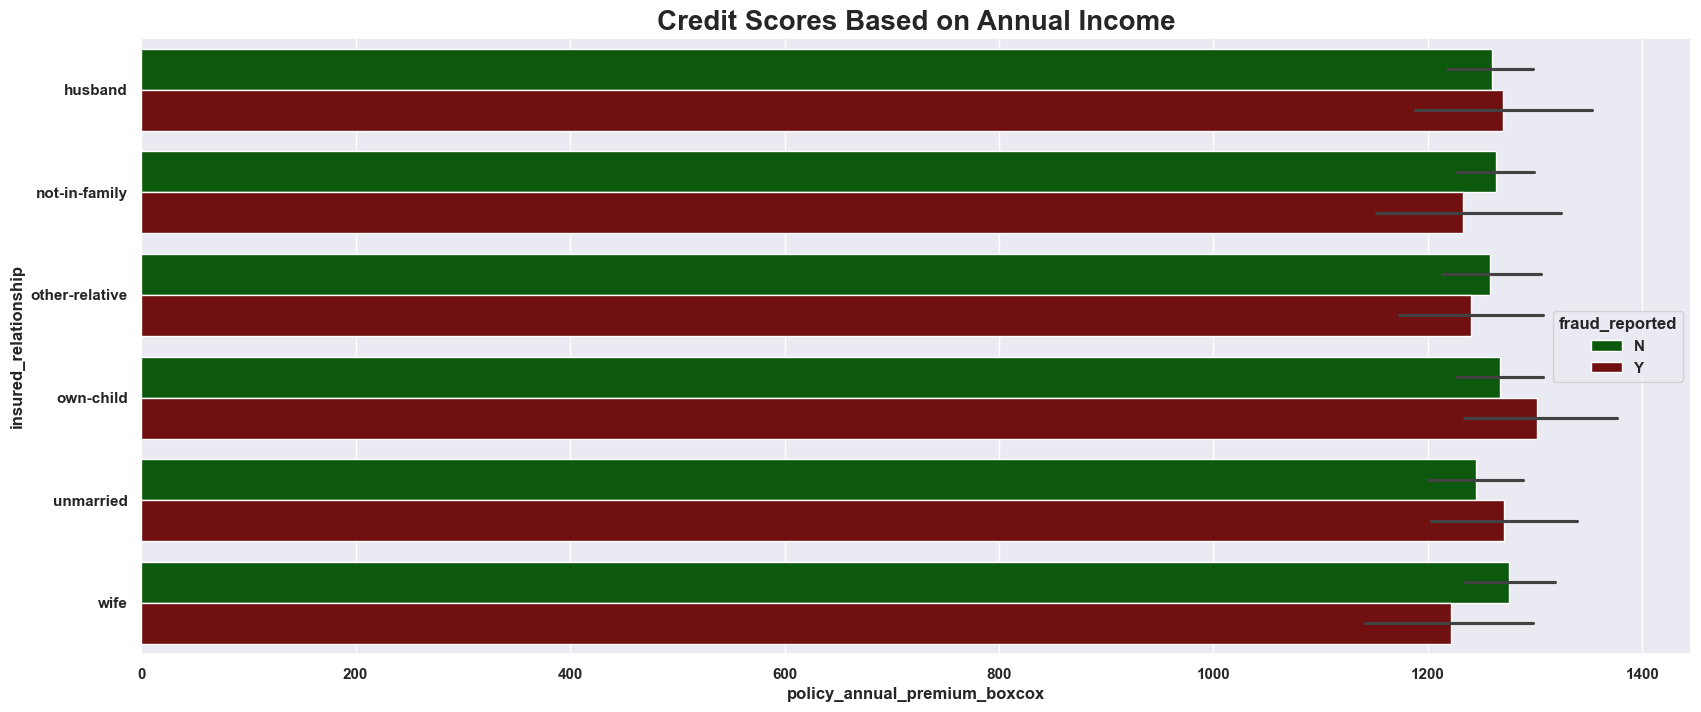

In [38]:
plt.figure(figsize=(20,8))
sns.barplot(data=df,x='policy_annual_premium_boxcox', y='insured_relationship',hue='fraud_reported',hue_order=['N','Y'],palette=['darkgreen','maroon'])
plt.title("Credit Scores Based on Annual Income",fontdict={'fontsize':20,'fontweight':'bold'})

### <p Style="color: Khaki">Correlation - Pearson's and Spearman's </p>

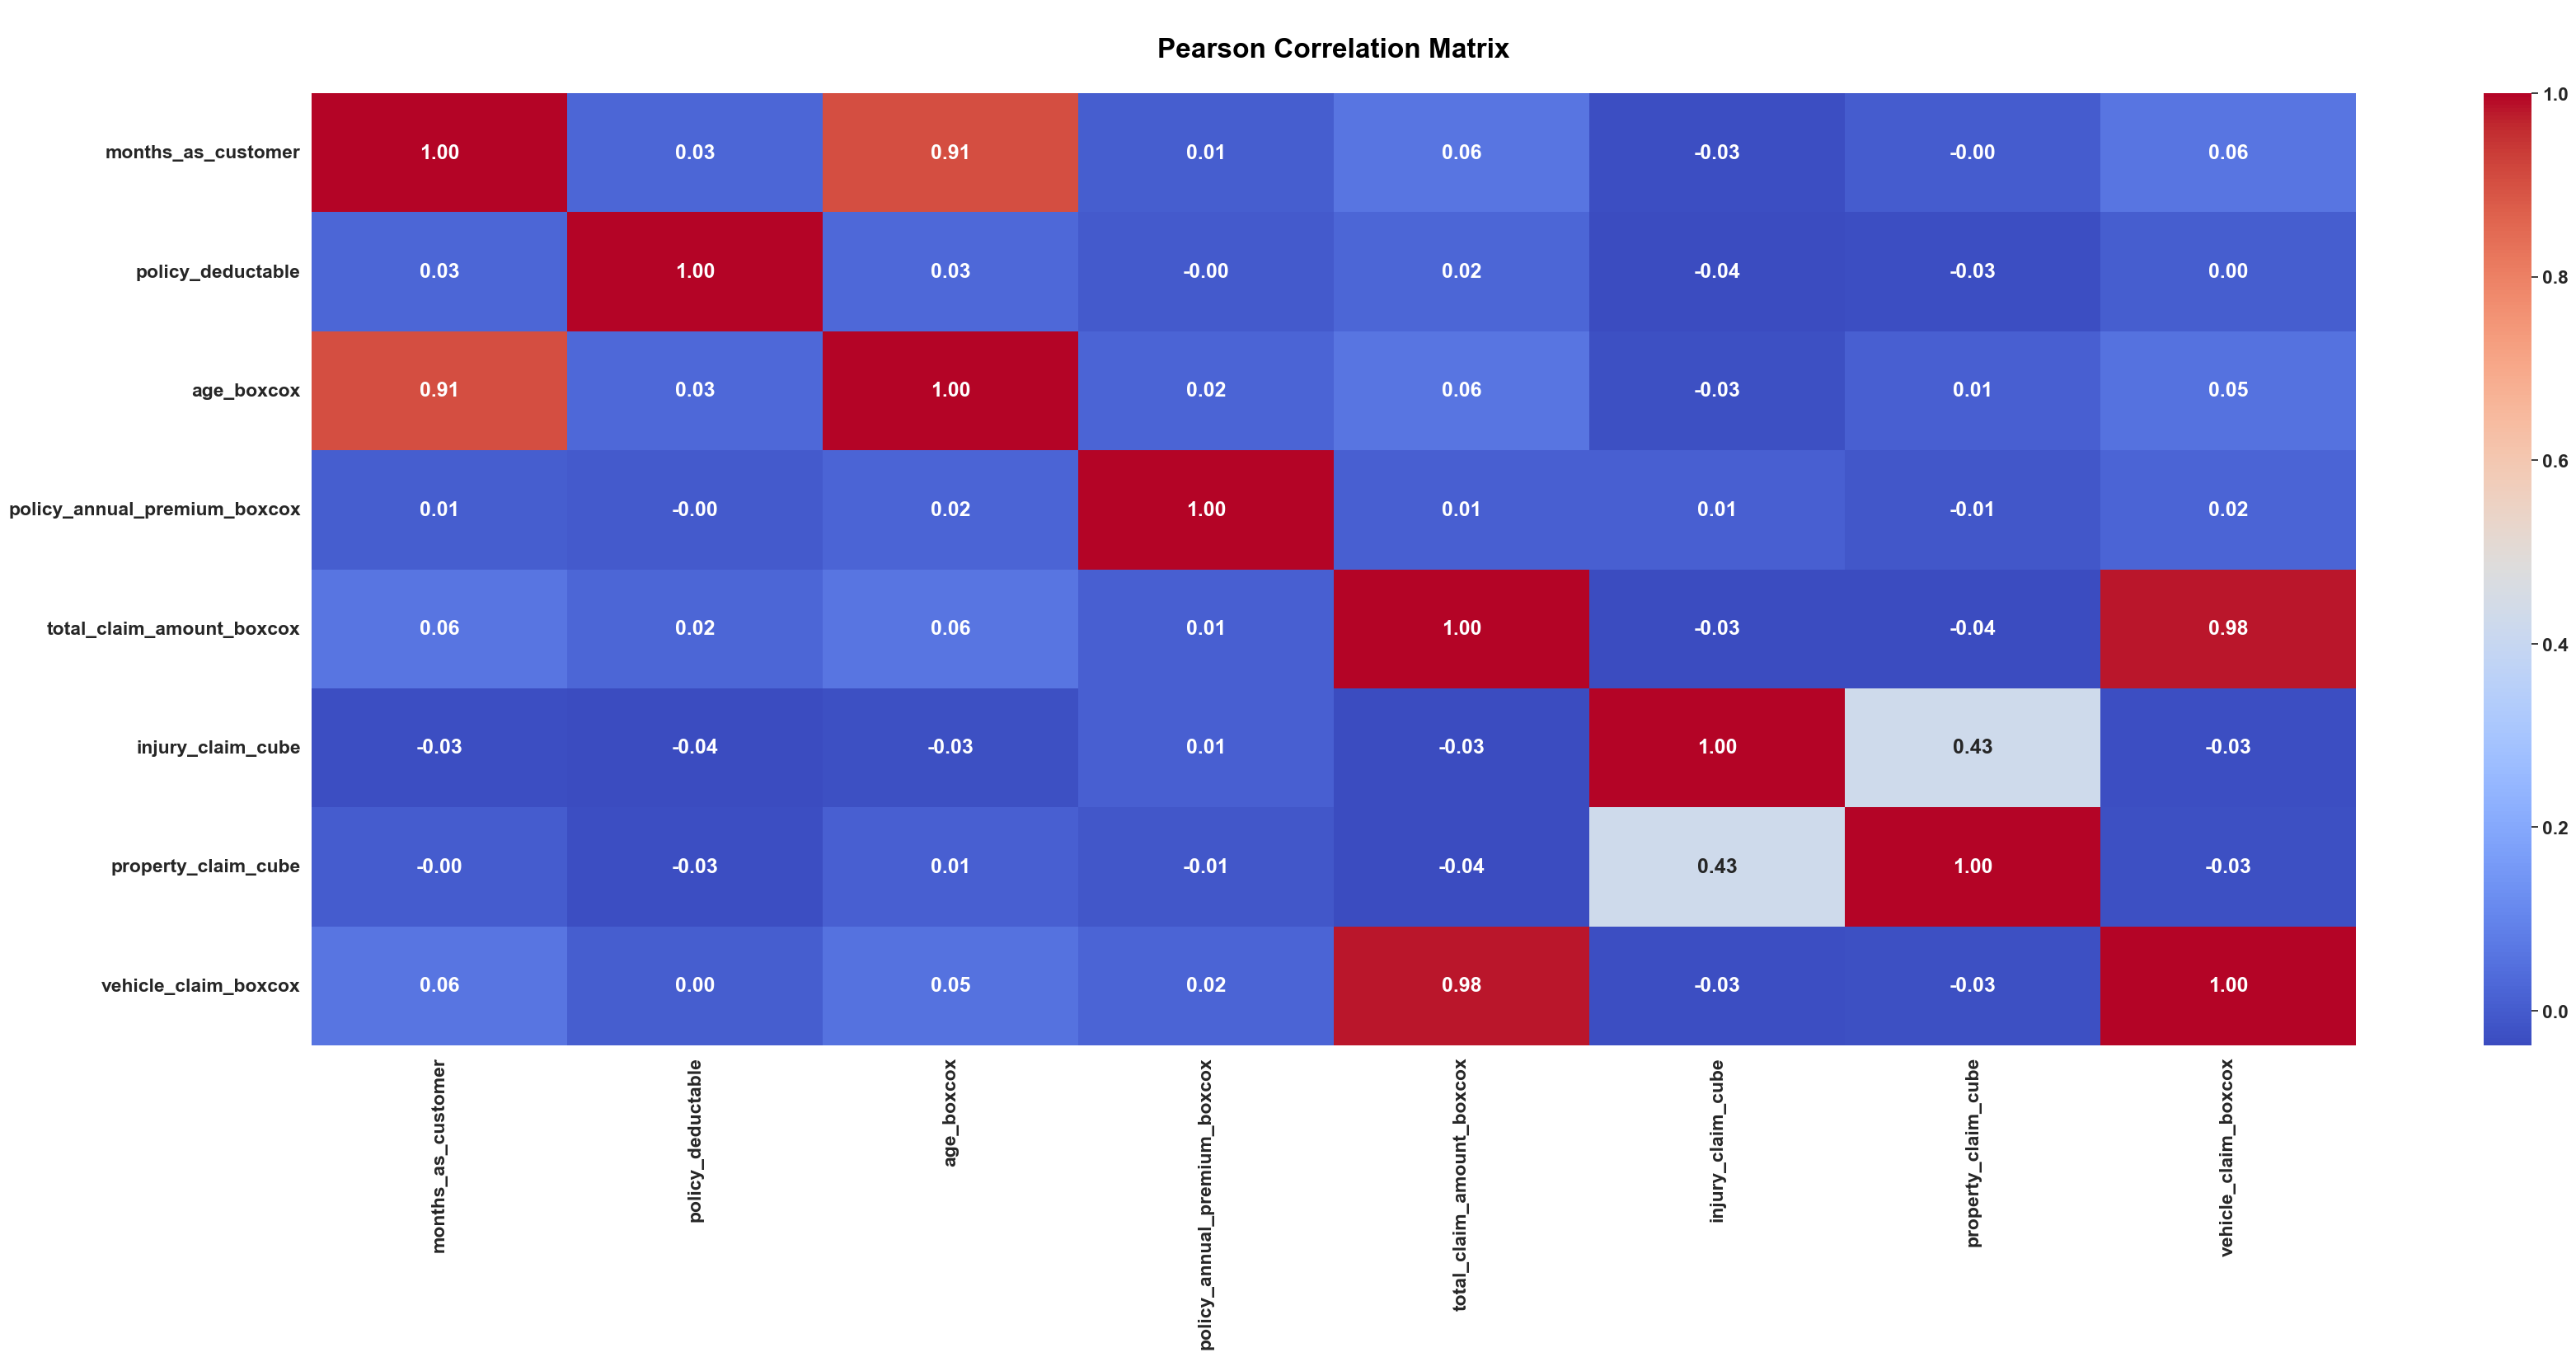

In [41]:
sns.set_theme(font_scale=1.5)

cor_col = df.select_dtypes(include='number')
correlation_matrix_pear = cor_col.corr(method='pearson')
plt.figure(figsize=(40,15))

sns.heatmap(correlation_matrix_pear,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nPearson Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})
plt.show()

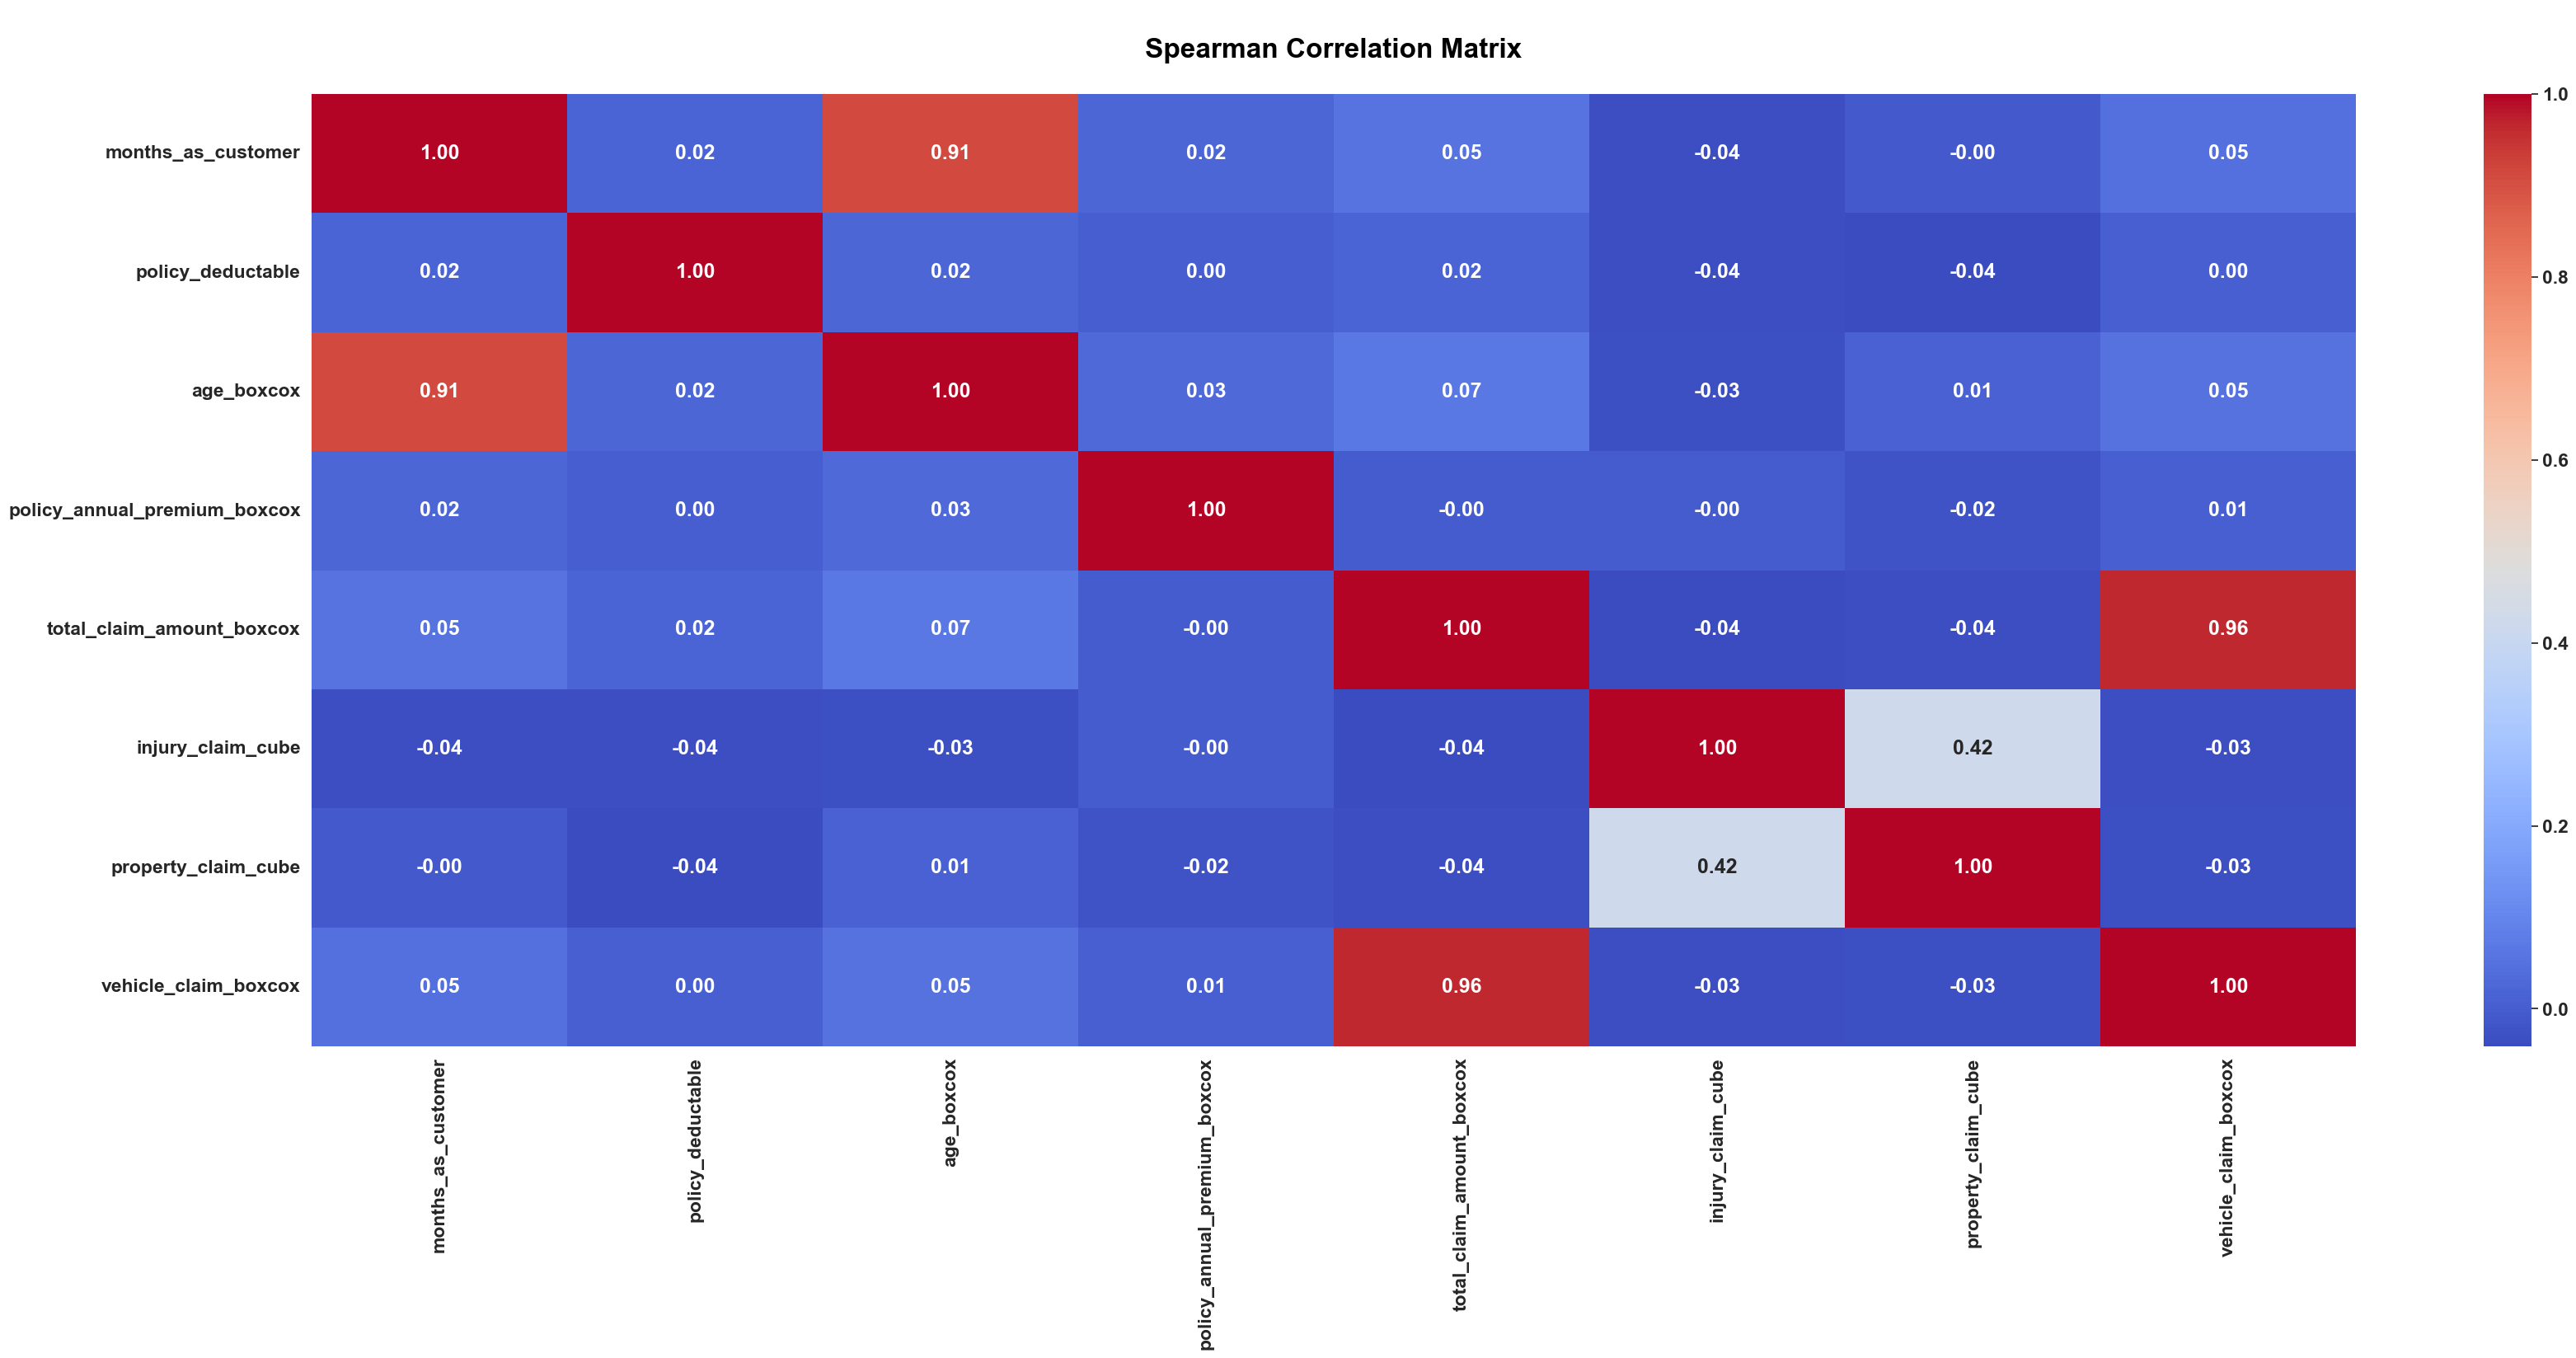

In [40]:
plt.figure(figsize=(40,15))

cor_col = df.select_dtypes(include='number')
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   months_as_customer            1000 non-null   int16         
 1   policy_bind_date              1000 non-null   datetime64[ns]
 2   policy_state                  1000 non-null   category      
 3   policy_deductable             1000 non-null   int16         
 4   insured_sex                   1000 non-null   category      
 5   insured_education_level       1000 non-null   category      
 6   insured_occupation            1000 non-null   category      
 7   insured_hobbies               1000 non-null   category      
 8   insured_relationship          1000 non-null   category      
 9   incident_date                 1000 non-null   datetime64[ns]
 10  incident_type                 1000 non-null   category      
 11  collision_type                1